# FD

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, recall_score, f1_score
from ForestDiffusion import ForestDiffusionModel

# Load the data
data = pd.read_csv('reduced_spambase.csv')
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Class distribution before augmentation
unique, counts = np.unique(y, return_counts=True)
class_dist_before = dict(zip(unique, counts))
print(f"Class distribution before augmentation: {class_dist_before}")

# Separate minority class
X_minority = X[y == 1]

# Train-test split for original data
X_train_orig, X_test, y_train_orig, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Train a Random Forest on the original data
clf_orig = RandomForestClassifier(random_state=42)
clf_orig.fit(X_train_orig, y_train_orig)

# Predict and calculate recall and F1 score on original data
y_pred_orig = clf_orig.predict(X_test)
recall_orig = recall_score(y_test, y_pred_orig)
f1_orig = f1_score(y_test, y_pred_orig)
print(f"Recall score (original data): {recall_orig:.4f}")
print(f"F1 score (original data): {f1_orig:.4f}")

# Loop over different augmentation factors
n_values = [0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3]  # Define different augmentation levels
# Forest Diffusion Model for data augmentation
forest_model = ForestDiffusionModel(X_minority, label_y=None, n_t=50, duplicate_K=100,
                                        bin_indexes=[], cat_indexes=[], int_indexes=[],
                                        diffusion_type='flow', n_jobs=-1)
for n in n_values:
    print(f"\nGenerating synthetic data with augmentation factor n={n}")
    
    # Generate synthetic data
    num_synthetic = round(len(X_minority) * n)
    X_minority_fake = forest_model.generate(batch_size=num_synthetic)

    # Combine the synthetic data with original data
    X_balanced = np.concatenate((X, X_minority_fake), axis=0)
    y_balanced = np.concatenate((y, np.ones(X_minority_fake.shape[0])), axis=0)

    # Class distribution after augmentation
    unique, counts = np.unique(y_balanced, return_counts=True)
    class_dist_after = dict(zip(unique, counts))
    print(f"Class distribution after augmentation: {class_dist_after}")

    # Train-test split for augmented data
    X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42, stratify=y_balanced)

    # Train a Random Forest on the augmented data
    clf_bal = RandomForestClassifier(random_state=42)
    clf_bal.fit(X_train_bal, y_train_bal)

    # Predict and calculate recall and F1 score on augmented data
    y_pred_bal = clf_bal.predict(X_test)
    recall_bal = recall_score(y_test, y_pred_bal)
    f1_bal = f1_score(y_test, y_pred_bal)
    print(f"Recall score (generated data, n={n}): {recall_bal:.4f}")
    print(f"F1 score (generated data, n={n}): {f1_bal:.4f}")

    # Print classification reports
    print("Classification Report (original data):\n", classification_report(y_test, y_pred_orig))
    print("Classification Report (generated data):\n", classification_report(y_test, y_pred_bal))


Class distribution before augmentation: {0: 2788, 1: 613}
Recall score (original data): 0.8478
F1 score (original data): 0.8914

Generating synthetic data with augmentation factor n=0.25
Class distribution after augmentation: {0.0: 2788, 1.0: 766}
Recall score (generated data, n=0.25): 0.8967
F1 score (generated data, n=0.25): 0.9167
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       837
           1       0.94      0.85      0.89       184

    accuracy                           0.96      1021
   macro avg       0.95      0.92      0.93      1021
weighted avg       0.96      0.96      0.96      1021

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.98      0.99      0.98       837
           1       0.94      0.90      0.92       184

    accuracy                           0.97      1021
   macro avg       0.96      0.94     

# FD_PCA

Optimal number of components: 48

Running augmentation with n=0.25
Recall (Balanced Data, n=0.25): 0.8804


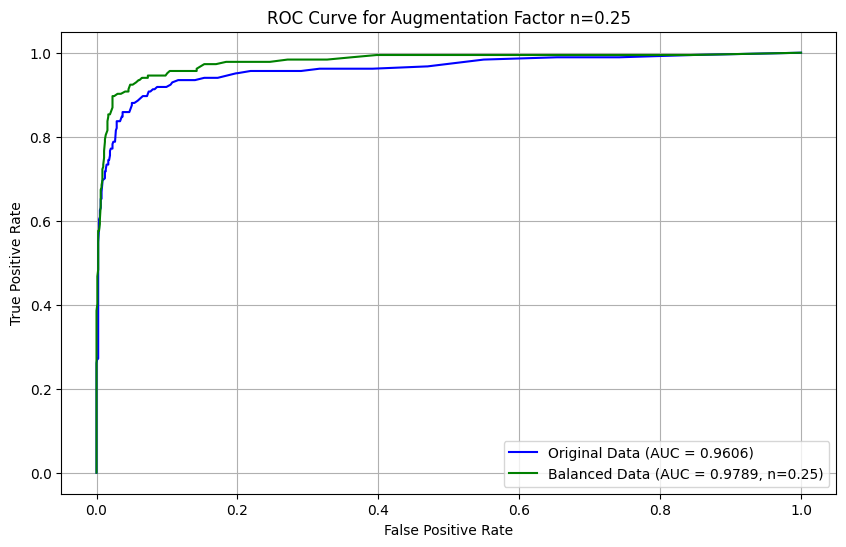


Running augmentation with n=0.5
Recall (Balanced Data, n=0.5): 0.8967


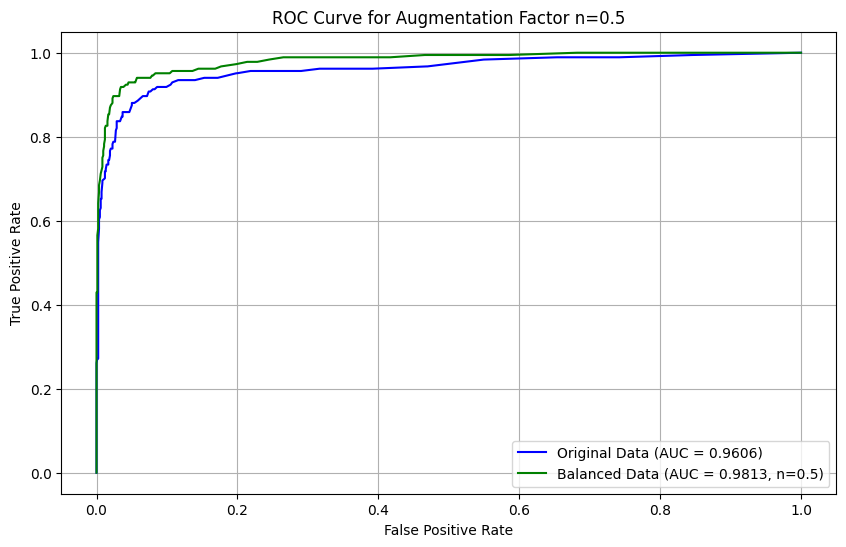


Running augmentation with n=0.75
Recall (Balanced Data, n=0.75): 0.8913


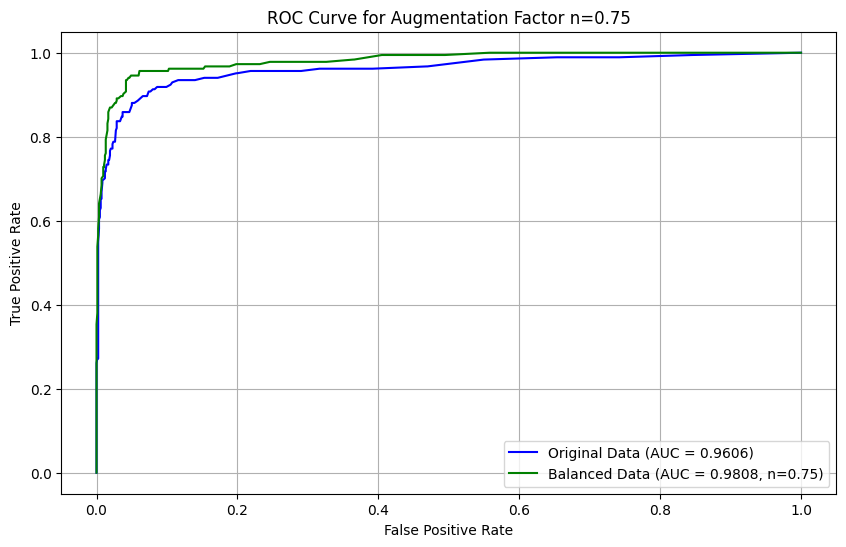


Running augmentation with n=1
Recall (Balanced Data, n=1): 0.9130


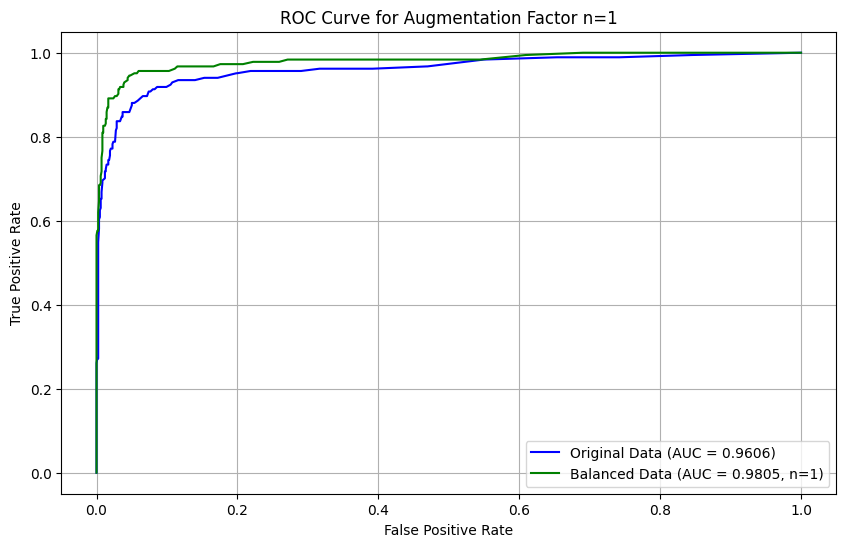


Running augmentation with n=1.25
Recall (Balanced Data, n=1.25): 0.9293


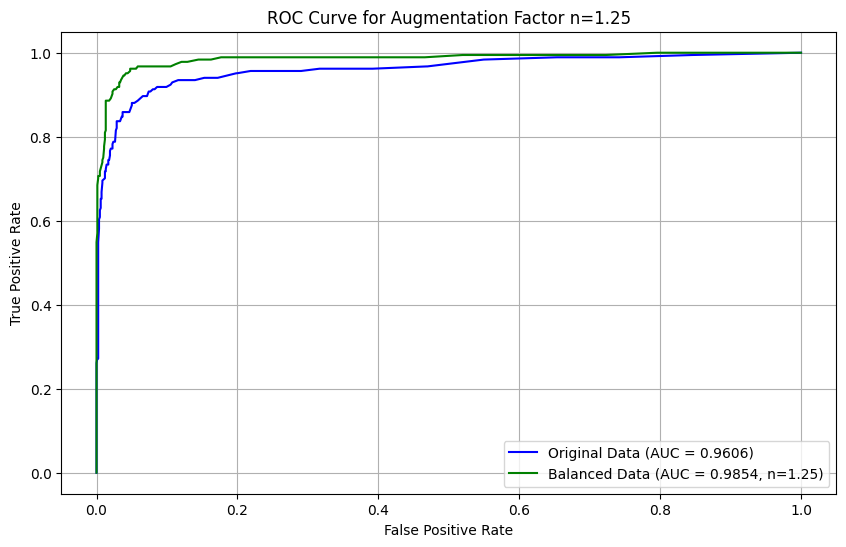


Running augmentation with n=1.5
Recall (Balanced Data, n=1.5): 0.9130


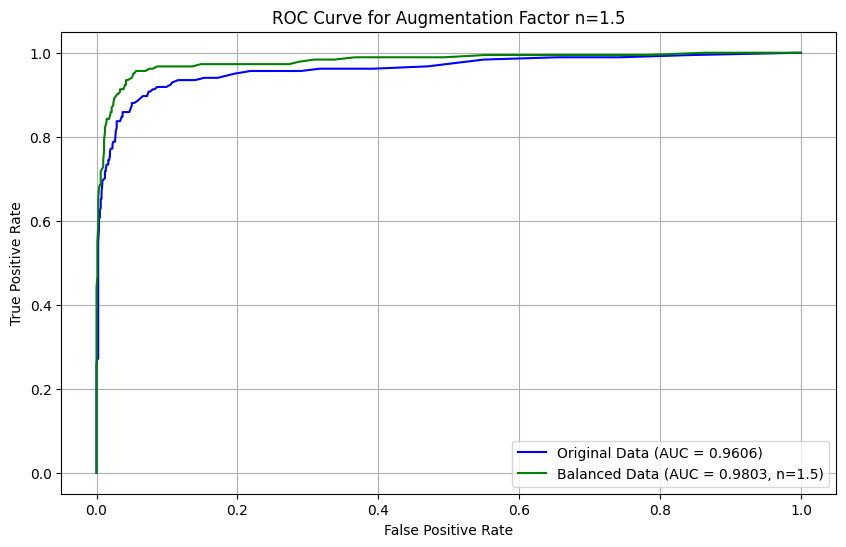


Running augmentation with n=1.75
Recall (Balanced Data, n=1.75): 0.9293


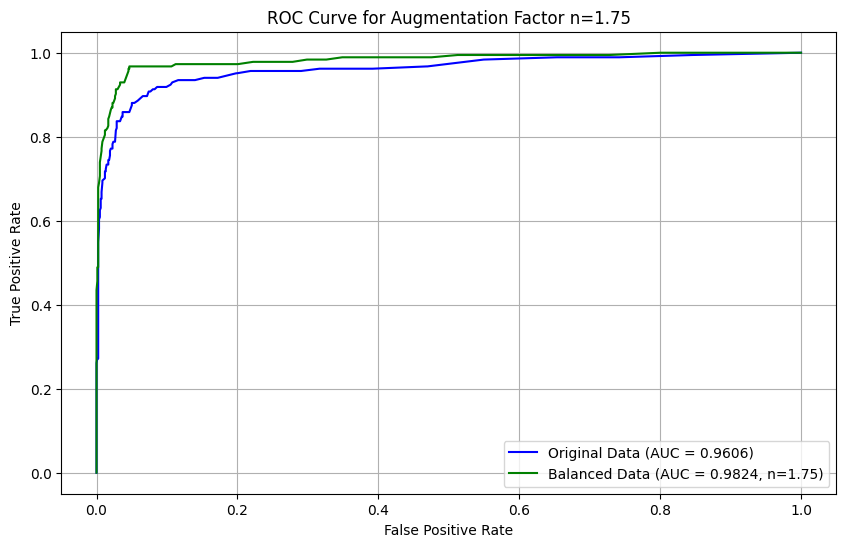


Running augmentation with n=2
Recall (Balanced Data, n=2): 0.9402


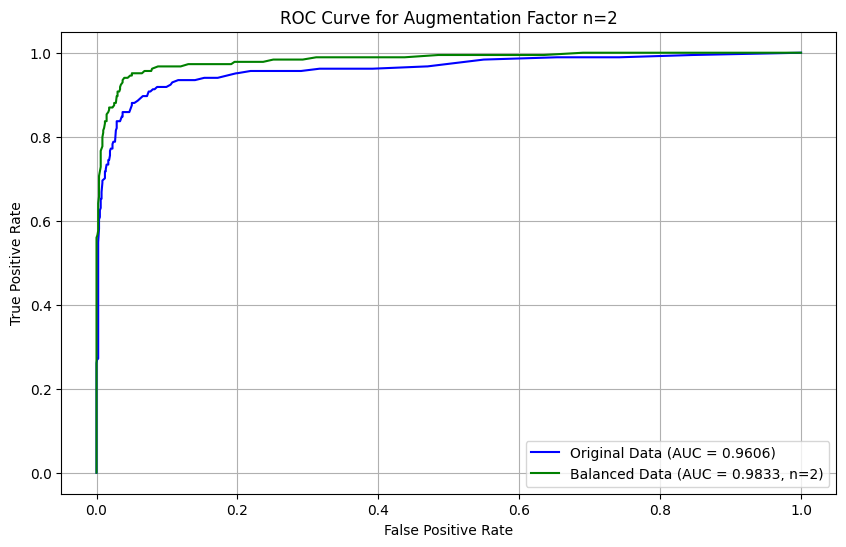


Running augmentation with n=2.25
Recall (Balanced Data, n=2.25): 0.9402


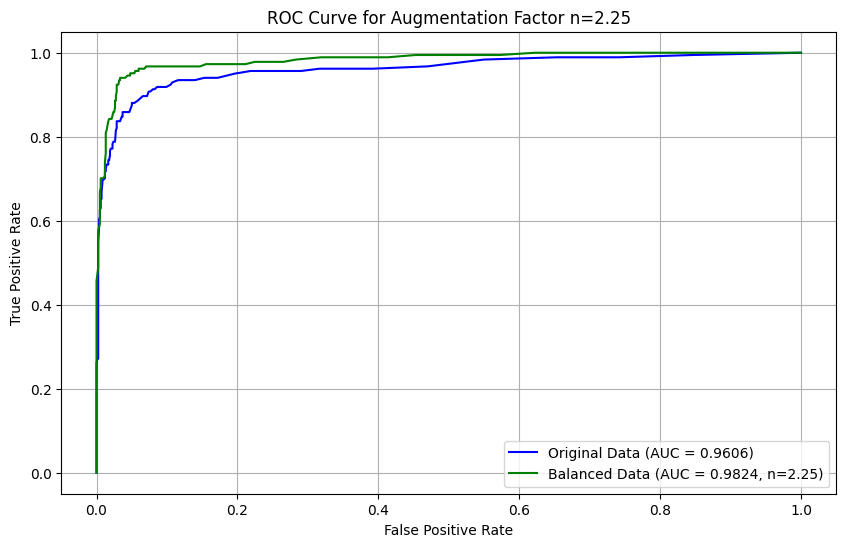


Running augmentation with n=2.5
Recall (Balanced Data, n=2.5): 0.9674


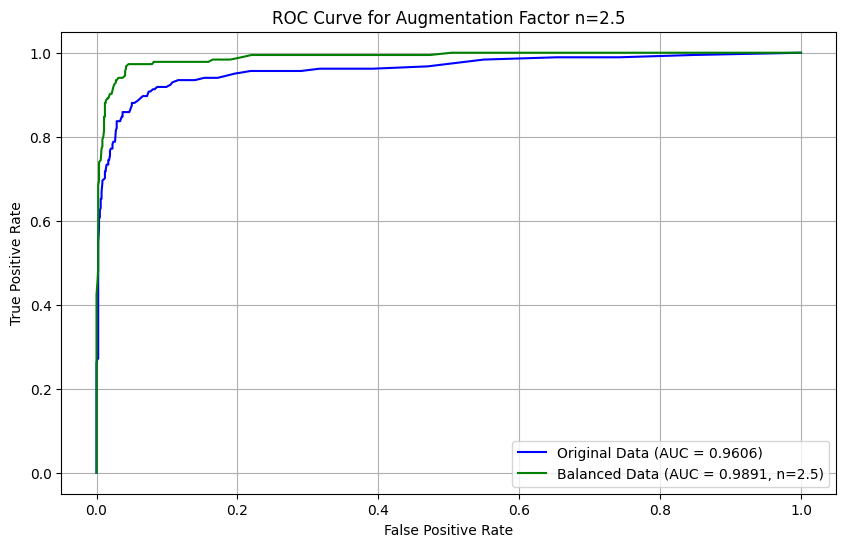


Running augmentation with n=2.75
Recall (Balanced Data, n=2.75): 0.9728


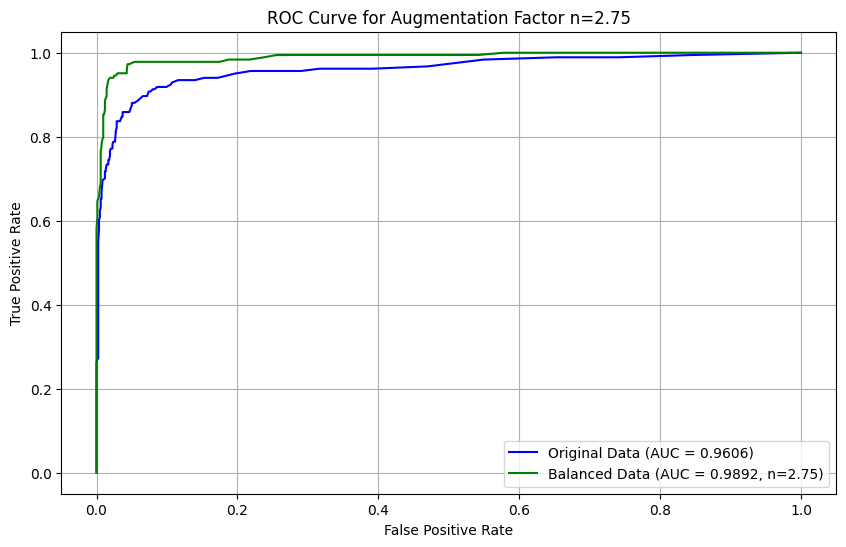


Running augmentation with n=3
Recall (Balanced Data, n=3): 0.9728


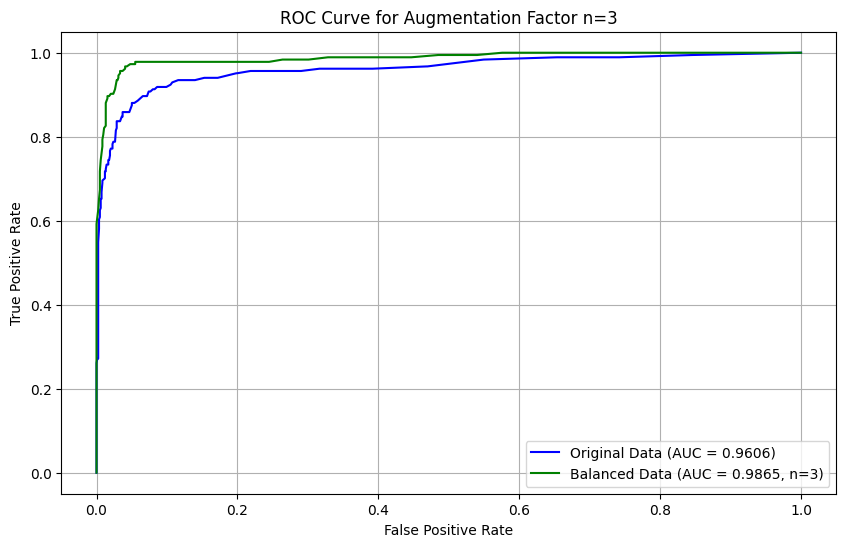

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, auc, recall_score
from collections import Counter
from sklearn.decomposition import PCA
from ForestDiffusion import ForestDiffusionModel
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('reduced_spambase.csv')
X = data.iloc[:, :-1]  # Features
y = data.iloc[:, -1]  # Target

# Standardize the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA and determine the optimal number of components
pca = PCA()
pca.fit(X_scaled)
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

best_n_components = np.argmax(cumulative_variance_ratio >= 0.95) + 1
print(f"Optimal number of components: {best_n_components}")

# Reduce dimensionality using PCA
pca = PCA(n_components=best_n_components)
X_reduced = pca.fit_transform(X_scaled)

# Split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=42, stratify=y)

# Train Random Forest on original data
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
recall_original = recall_score(y_test, y_pred)
fpr_original, tpr_original, _ = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
auc_original = auc(fpr_original, tpr_original)

class_counts = Counter(y)
minority_class = min(class_counts, key=class_counts.get)
X_minority_reduced = X_reduced[y == minority_class]
forest_model = ForestDiffusionModel(
        X_minority_reduced, label_y=None, n_t=50, duplicate_K=100,
        bin_indexes=[], cat_indexes=[], int_indexes=[],
        diffusion_type='flow', n_jobs=-1)
# Loop over different augmentation factors
for n in [0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3]:
    print(f"\nRunning augmentation with n={n}")
    
    
    
    num_samples_to_generate = round(len(X_minority_reduced) * n)
    generated_samples_reduced = forest_model.generate(batch_size=num_samples_to_generate)
    
    # Create balanced dataset
    X_balanced_reduced = np.vstack([X_reduced, generated_samples_reduced])
    y_balanced = np.hstack([y, [minority_class] * len(generated_samples_reduced)])
    
    X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(
        X_balanced_reduced, y_balanced, test_size=0.3, random_state=42, stratify=y_balanced)
    
    # Train Random Forest on balanced dataset
    rf_bal = RandomForestClassifier(random_state=42)
    rf_bal.fit(X_train_bal, y_train_bal)
    
    y_pred_balanced = rf_bal.predict(X_test)
    recall_balanced = recall_score(y_test, y_pred_balanced)
    fpr_balanced, tpr_balanced, _ = roc_curve(y_test, rf_bal.predict_proba(X_test)[:, 1])
    auc_balanced = auc(fpr_balanced, tpr_balanced)
    
    print(f"Recall (Balanced Data, n={n}): {recall_balanced:.4f}")
    
    plt.figure(figsize=(10, 6))
    plt.plot(fpr_original, tpr_original, label=f'Original Data (AUC = {auc_original:.4f})', color='blue')
    plt.plot(fpr_balanced, tpr_balanced, label=f'Balanced Data (AUC = {auc_balanced:.4f}, n={n})', color='green')
    plt.title(f"ROC Curve for Augmentation Factor n={n}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)
    plt.show()


# DCR, NNDR [Balanced, Original]

# FD

Class distribution before augmentation: {0: 2788, 1: 613}
Recall score (original data): 0.8478
F1 score (original data): 0.8914

--- Processing n = 0.25 ---
Class distribution after augmentation: {0.0: 2788, 1.0: 766}
Recall score (generated data, n=0.25): 0.8967
F1 score (generated data, n=0.25): 0.9167
Average DCR (n=0.25): 3.6389


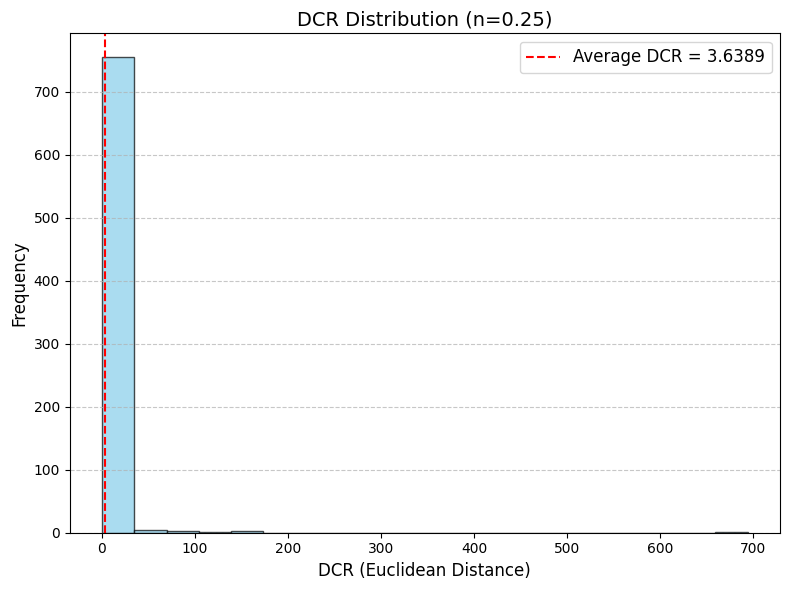

Average NNDR (n=0.25): 0.1658


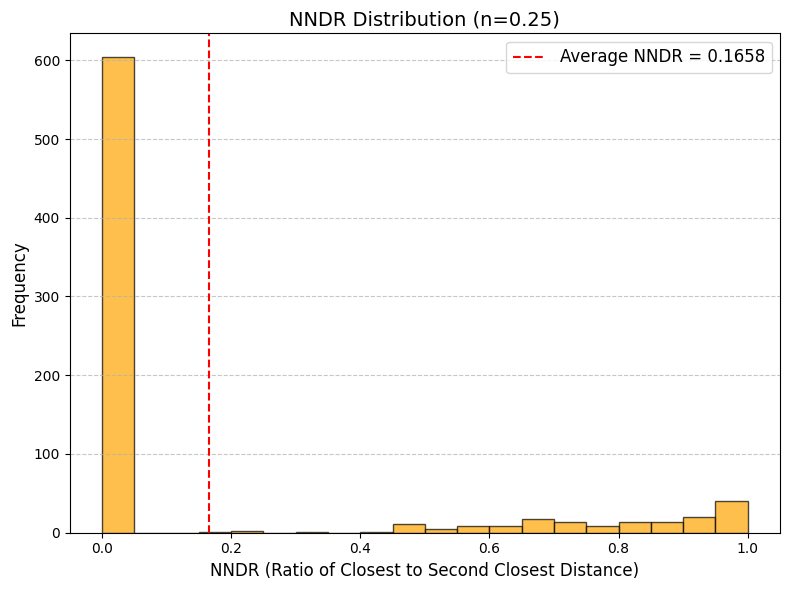


--- Processing n = 0.5 ---
Class distribution after augmentation: {0.0: 2788, 1.0: 919}
Recall score (generated data, n=0.5): 0.8859
F1 score (generated data, n=0.5): 0.9157
Average DCR (n=0.5): 5.1386


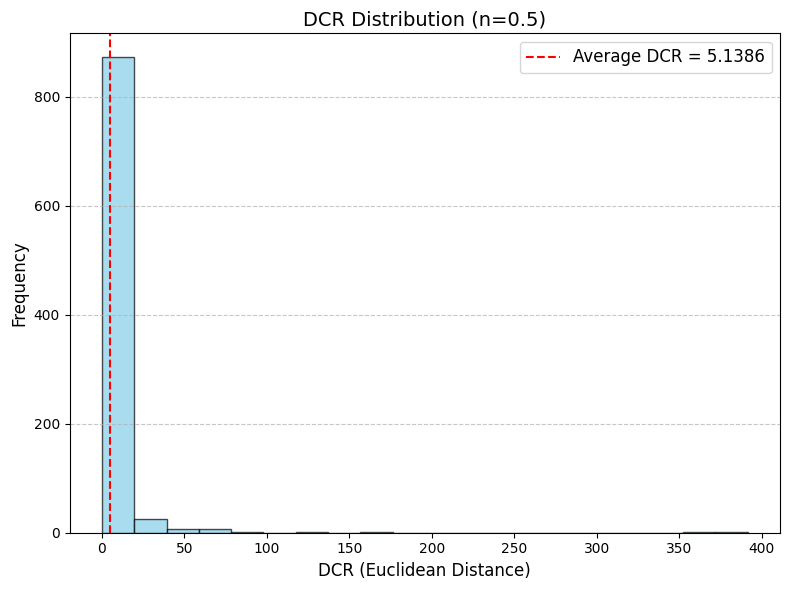

Average NNDR (n=0.5): 0.2642


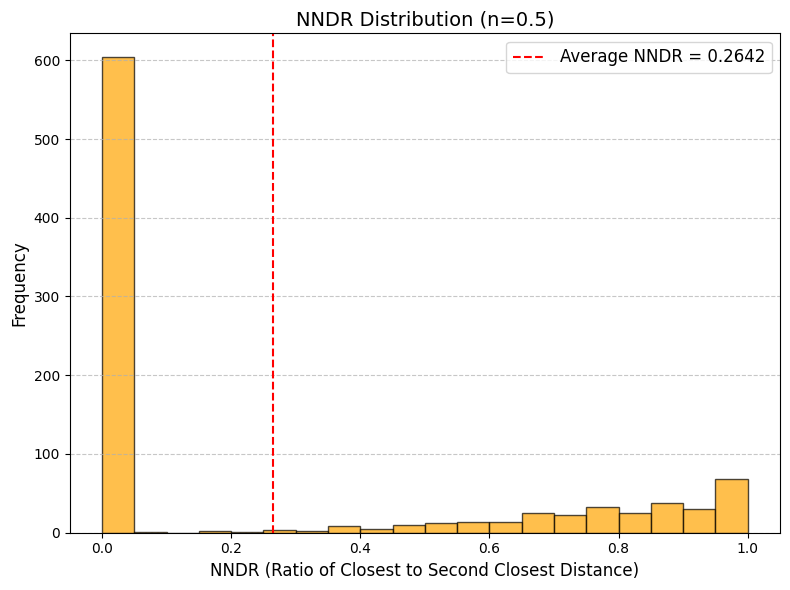


--- Processing n = 0.75 ---
Class distribution after augmentation: {0.0: 2788, 1.0: 1073}
Recall score (generated data, n=0.75): 0.9130
F1 score (generated data, n=0.75): 0.9256
Average DCR (n=0.75): 7.1538


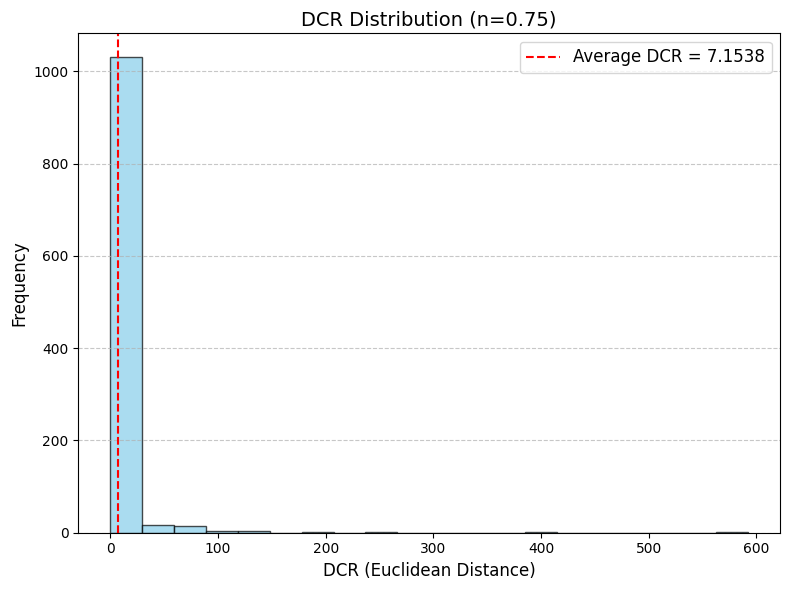

Average NNDR (n=0.75): 0.3478


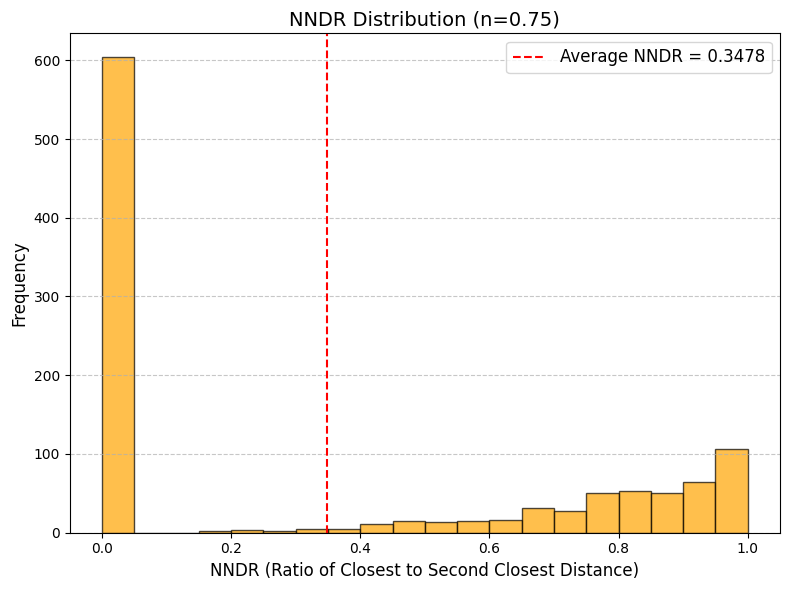


--- Processing n = 1.0 ---
Class distribution after augmentation: {0.0: 2788, 1.0: 1226}
Recall score (generated data, n=1.0): 0.9130
F1 score (generated data, n=1.0): 0.9256
Average DCR (n=1.0): 11.3876


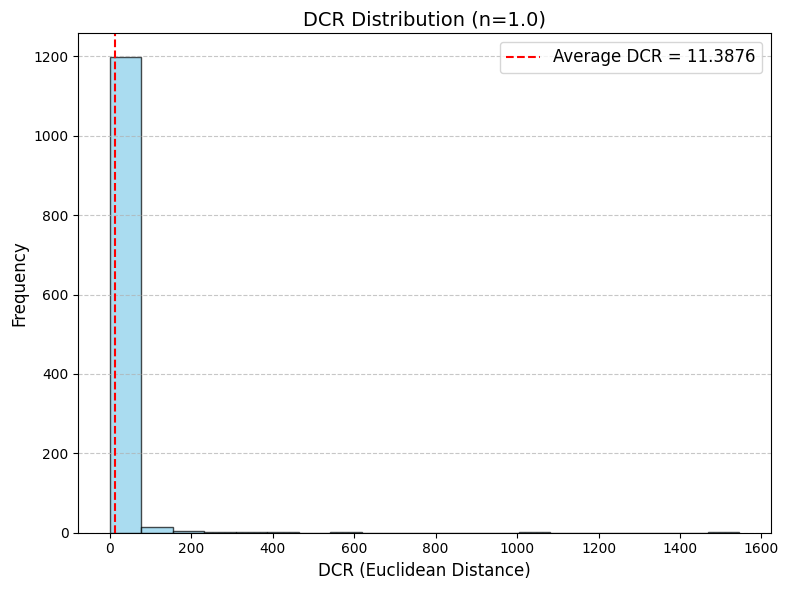

Average NNDR (n=1.0): 0.4041


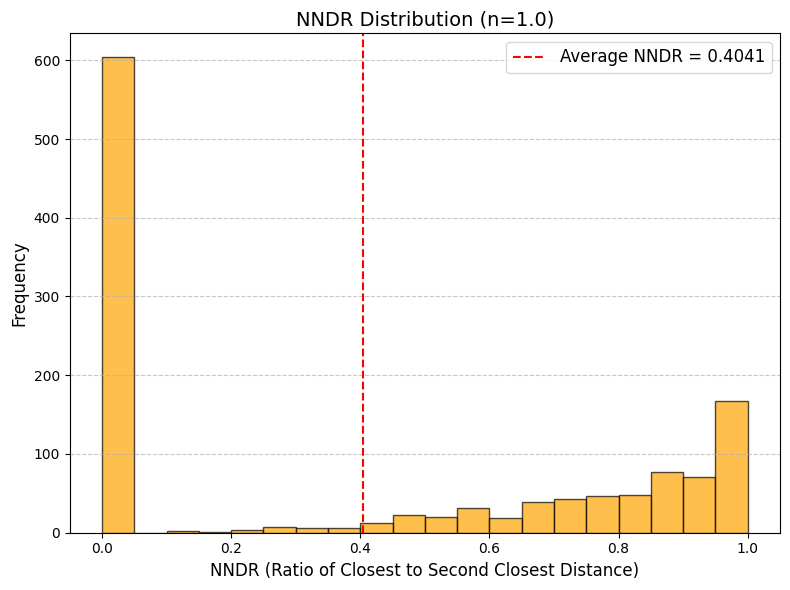


--- Processing n = 1.25 ---
Class distribution after augmentation: {0.0: 2788, 1.0: 1379}
Recall score (generated data, n=1.25): 0.9348
F1 score (generated data, n=1.25): 0.9348
Average DCR (n=1.25): 13.9500


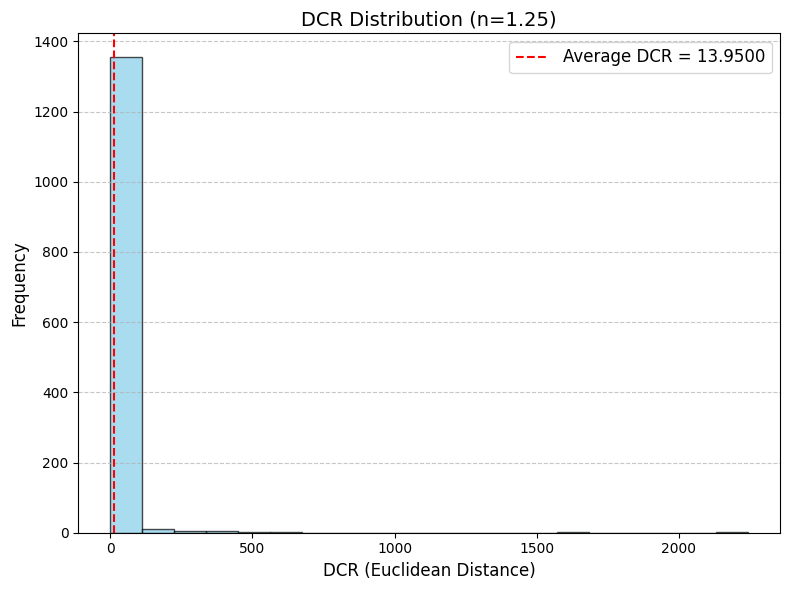

Average NNDR (n=1.25): 0.4383


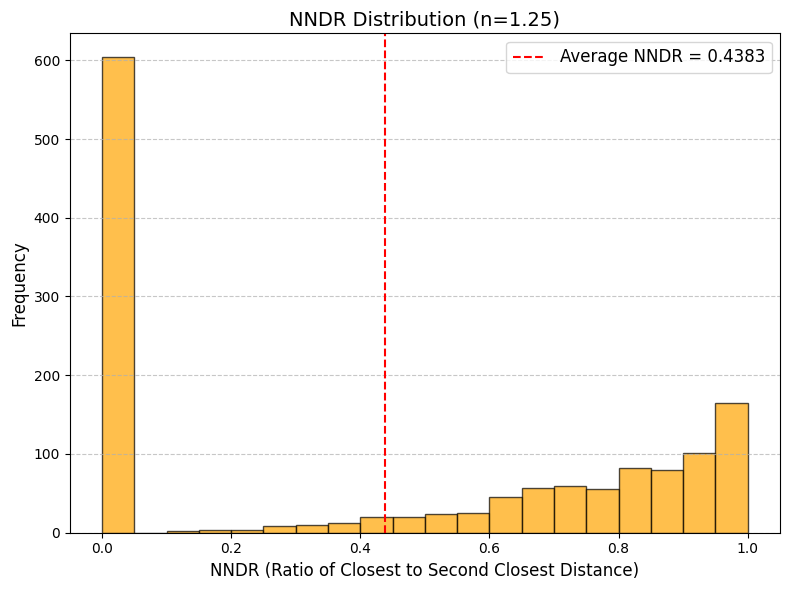


--- Processing n = 1.5 ---
Class distribution after augmentation: {0.0: 2788, 1.0: 1533}
Recall score (generated data, n=1.5): 0.9239
F1 score (generated data, n=1.5): 0.9290
Average DCR (n=1.5): 11.8161


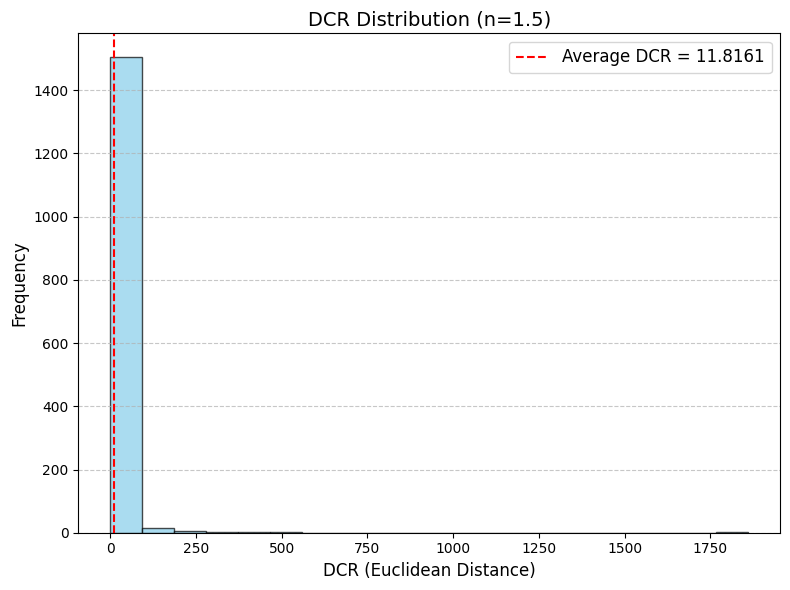

Average NNDR (n=1.5): 0.4821


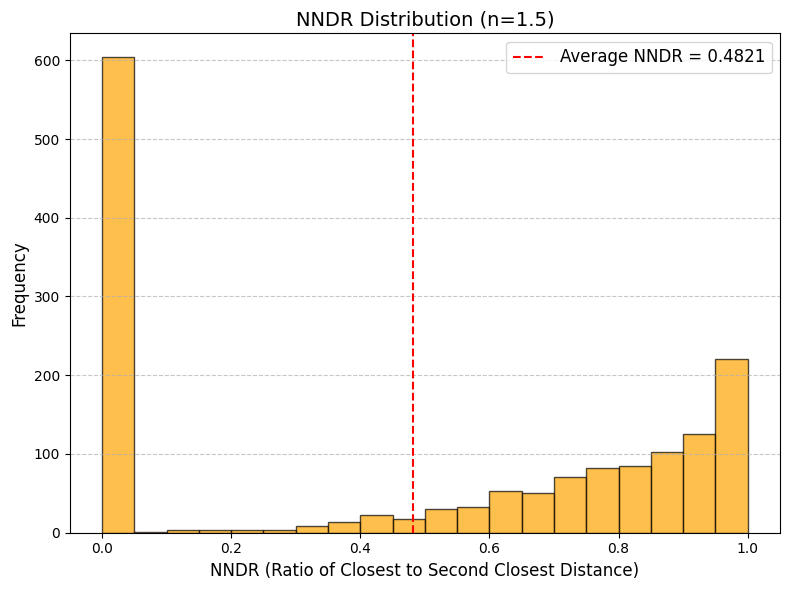


--- Processing n = 1.75 ---
Class distribution after augmentation: {0.0: 2788, 1.0: 1686}
Recall score (generated data, n=1.75): 0.9239
F1 score (generated data, n=1.75): 0.9315
Average DCR (n=1.75): 15.1914


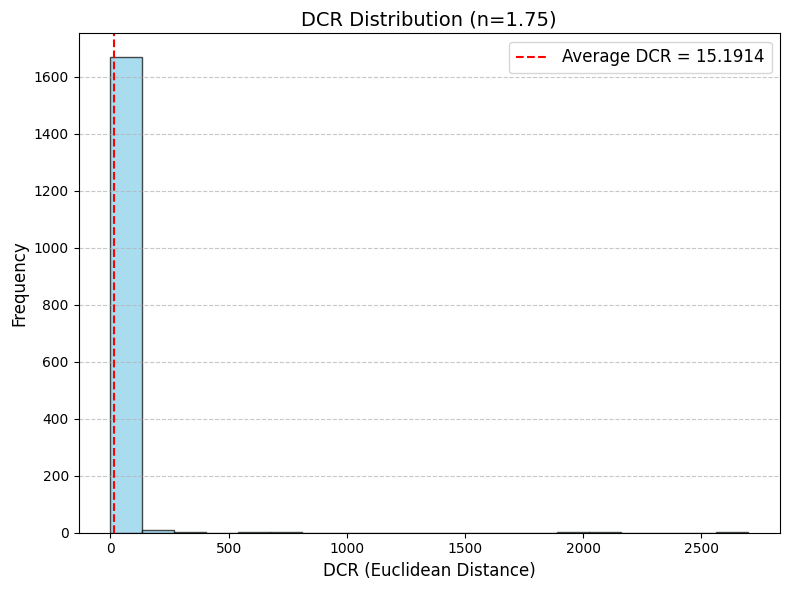

Average NNDR (n=1.75): 0.5123


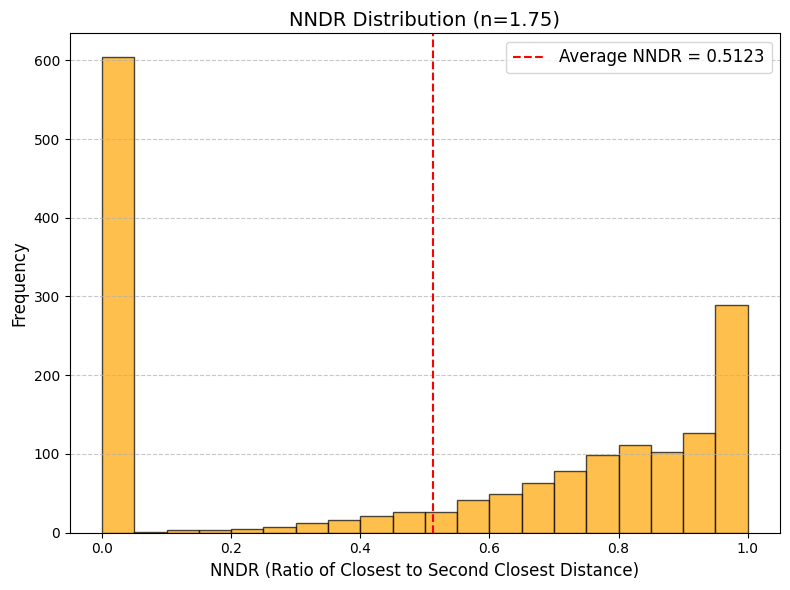


--- Processing n = 2.0 ---
Class distribution after augmentation: {0.0: 2788, 1.0: 1839}
Recall score (generated data, n=2.0): 0.9185
F1 score (generated data, n=2.0): 0.9235
Average DCR (n=2.0): 13.3147


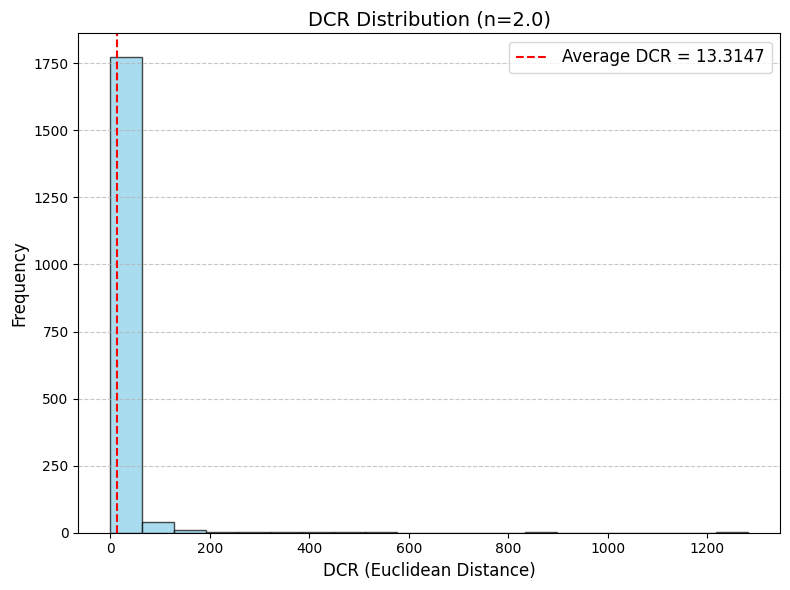

Average NNDR (n=2.0): 0.5280


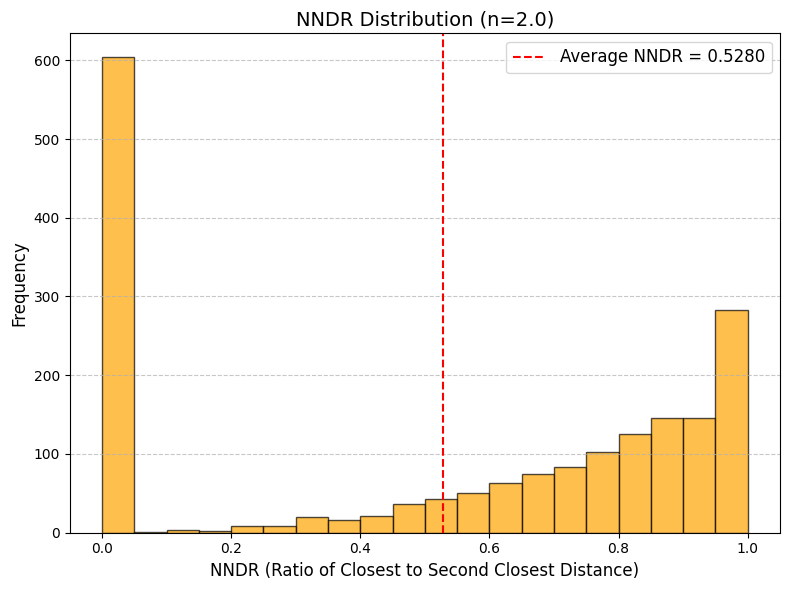


--- Processing n = 2.25 ---
Class distribution after augmentation: {0.0: 2788, 1.0: 1992}
Recall score (generated data, n=2.25): 0.9239
F1 score (generated data, n=2.25): 0.9239
Average DCR (n=2.25): 14.9653


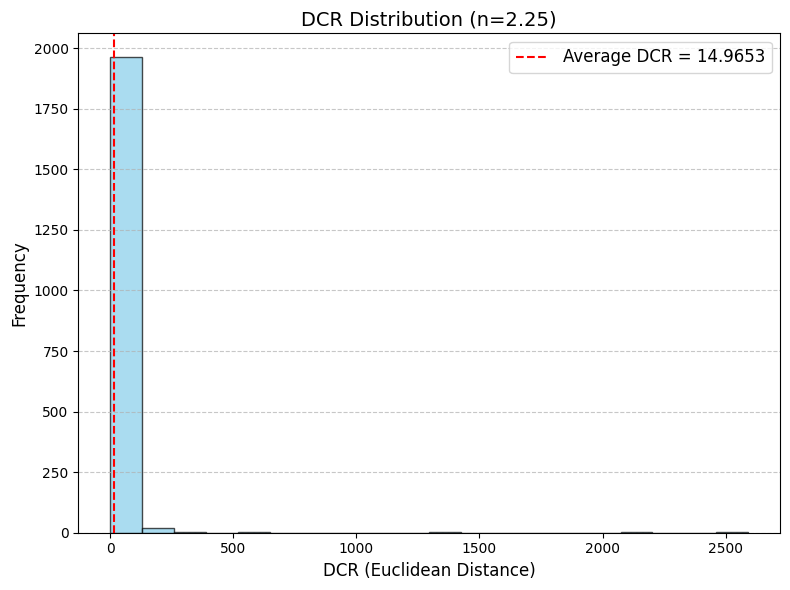

Average NNDR (n=2.25): 0.5479


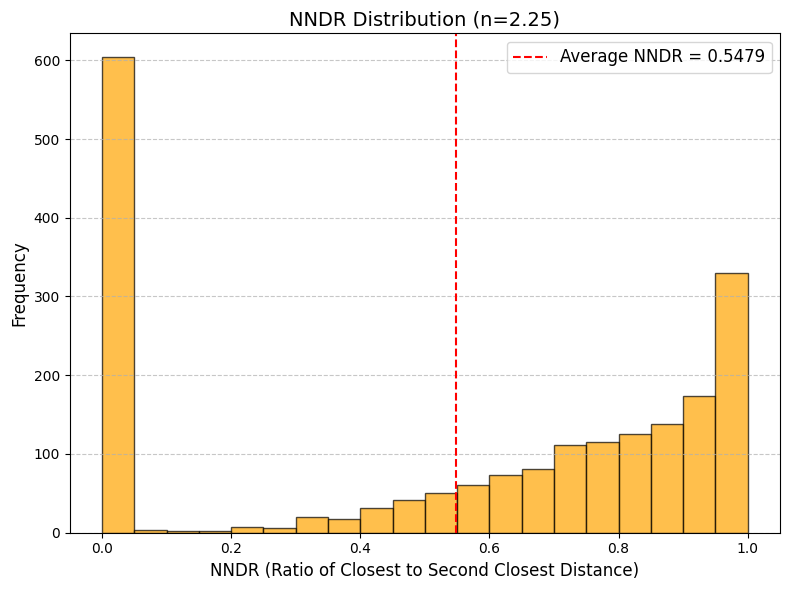


--- Processing n = 2.5 ---
Class distribution after augmentation: {0.0: 2788, 1.0: 2145}
Recall score (generated data, n=2.5): 0.9511
F1 score (generated data, n=2.5): 0.9358
Average DCR (n=2.5): 13.5665


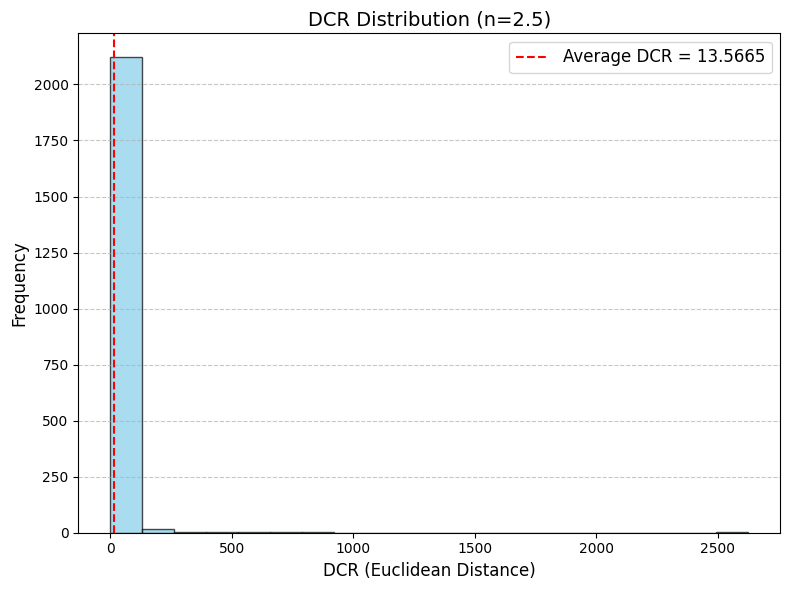

Average NNDR (n=2.5): 0.5657


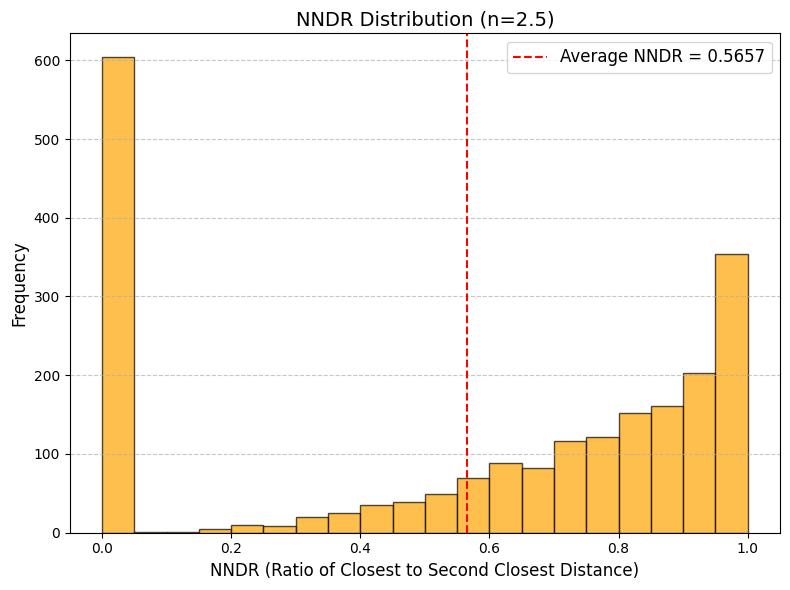


--- Processing n = 2.75 ---
Class distribution after augmentation: {0.0: 2788, 1.0: 2299}
Recall score (generated data, n=2.75): 0.9457
F1 score (generated data, n=2.75): 0.9355
Average DCR (n=2.75): 16.0892


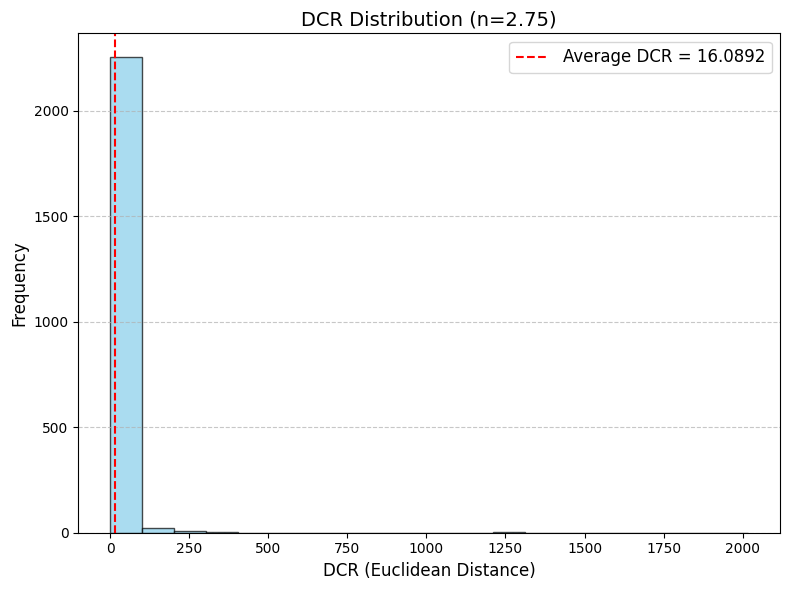

Average NNDR (n=2.75): 0.5817


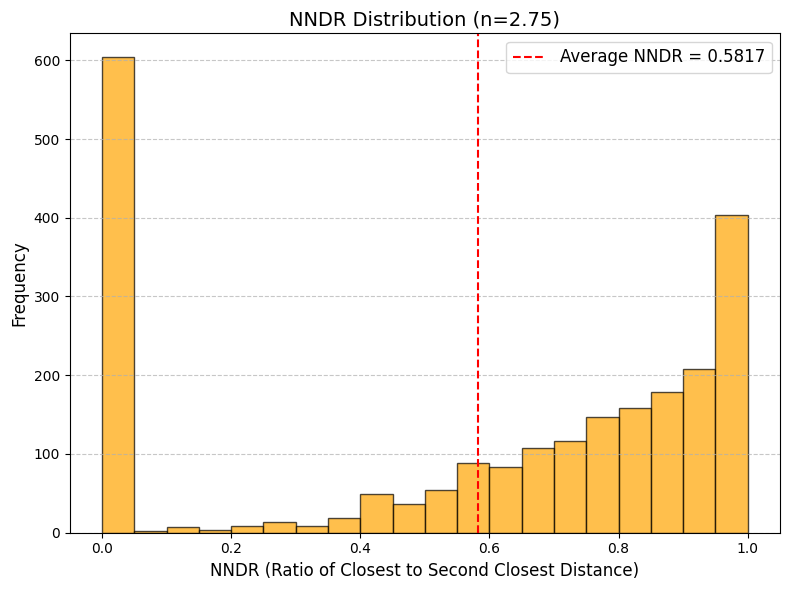


--- Processing n = 3 ---
Class distribution after augmentation: {0.0: 2788, 1.0: 2452}
Recall score (generated data, n=3): 0.9402
F1 score (generated data, n=3): 0.9326
Average DCR (n=3): 14.5800


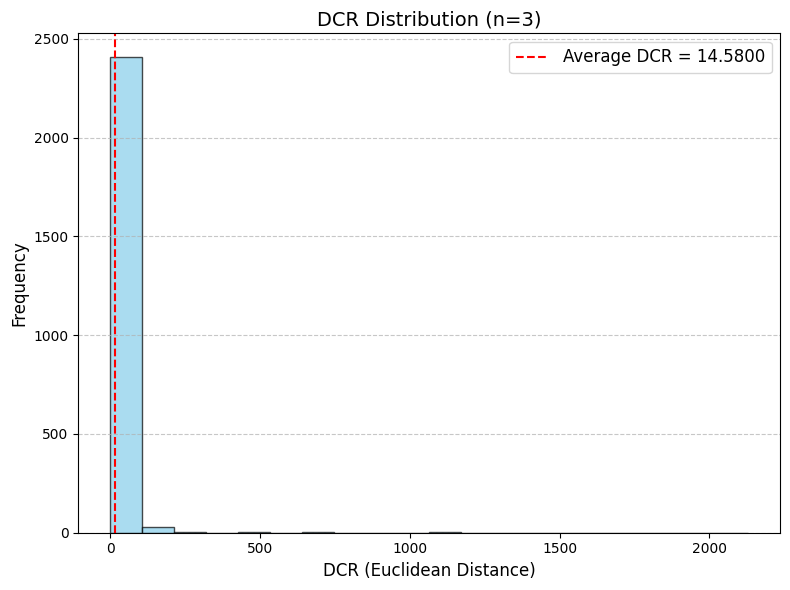

Average NNDR (n=3): 0.5916


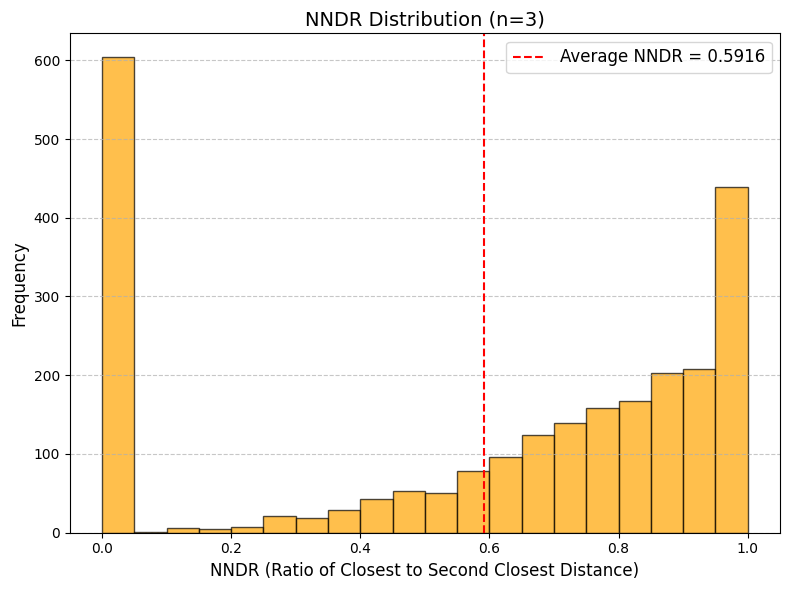


--- Processing n = 3.25 ---
Class distribution after augmentation: {0.0: 2788, 1.0: 2605}
Recall score (generated data, n=3.25): 0.9457
F1 score (generated data, n=3.25): 0.9431
Average DCR (n=3.25): 15.1952


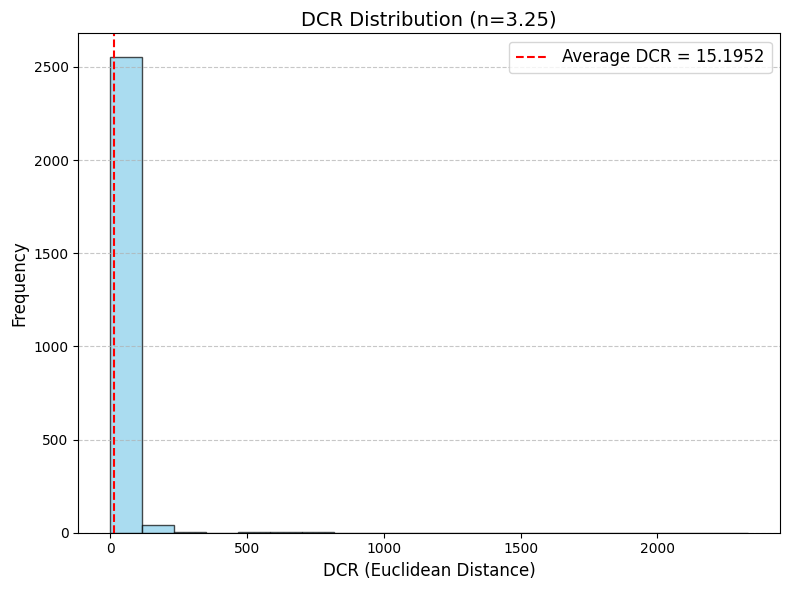

Average NNDR (n=3.25): 0.6067


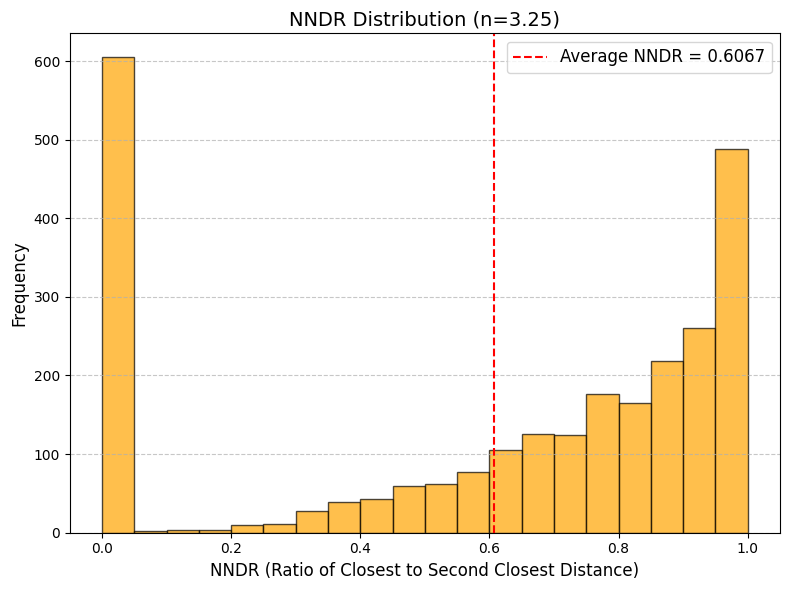


--- Summary of Results ---
n = 0.25: Recall = 0.8967, F1 = 0.9167, Avg DCR = 3.6389, Avg NNDR = 0.1658
n = 0.5: Recall = 0.8859, F1 = 0.9157, Avg DCR = 5.1386, Avg NNDR = 0.2642
n = 0.75: Recall = 0.9130, F1 = 0.9256, Avg DCR = 7.1538, Avg NNDR = 0.3478
n = 1.0: Recall = 0.9130, F1 = 0.9256, Avg DCR = 11.3876, Avg NNDR = 0.4041
n = 1.25: Recall = 0.9348, F1 = 0.9348, Avg DCR = 13.9500, Avg NNDR = 0.4383
n = 1.5: Recall = 0.9239, F1 = 0.9290, Avg DCR = 11.8161, Avg NNDR = 0.4821
n = 1.75: Recall = 0.9239, F1 = 0.9315, Avg DCR = 15.1914, Avg NNDR = 0.5123
n = 2.0: Recall = 0.9185, F1 = 0.9235, Avg DCR = 13.3147, Avg NNDR = 0.5280
n = 2.25: Recall = 0.9239, F1 = 0.9239, Avg DCR = 14.9653, Avg NNDR = 0.5479
n = 2.5: Recall = 0.9511, F1 = 0.9358, Avg DCR = 13.5665, Avg NNDR = 0.5657
n = 2.75: Recall = 0.9457, F1 = 0.9355, Avg DCR = 16.0892, Avg NNDR = 0.5817
n = 3: Recall = 0.9402, F1 = 0.9326, Avg DCR = 14.5800, Avg NNDR = 0.5916
n = 3.25: Recall = 0.9457, F1 = 0.9431, Avg DCR = 15.1952, 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, recall_score, f1_score, pairwise_distances
from ForestDiffusion import ForestDiffusionModel

# ------------------------------
# Load Data and Preprocessing
# ------------------------------

# Load the data
data = pd.read_csv('reduced_spambase.csv')
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Class distribution before augmentation
unique, counts = np.unique(y, return_counts=True)
class_dist_before = dict(zip(unique, counts))
print(f"Class distribution before augmentation: {class_dist_before}")

# Separate minority class
X_minority = X[y == 1]

# Train-test split for original data
X_train_orig, X_test, y_train_orig, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Train a Random Forest on the original data
clf_orig = RandomForestClassifier(random_state=42)
clf_orig.fit(X_train_orig, y_train_orig)

# Predict and calculate recall and F1 score on original data
y_pred_orig = clf_orig.predict(X_test)
recall_orig = recall_score(y_test, y_pred_orig)
f1_orig = f1_score(y_test, y_pred_orig)
print(f"Recall score (original data): {recall_orig:.4f}")
print(f"F1 score (original data): {f1_orig:.4f}")

# ------------------------------
# Functions for DCR and NNDR
# ------------------------------

def calculate_dcr(synthetic_data, real_data):
    distances = pairwise_distances(synthetic_data, real_data, metric='euclidean')
    min_distances = np.min(distances, axis=1)
    avg_dcr = np.mean(min_distances)
    return avg_dcr, min_distances

def calculate_nndr(synthetic_data, real_data):
    distances = pairwise_distances(synthetic_data, real_data, metric='euclidean')
    sorted_distances = np.sort(distances, axis=1)
    epsilon = 1e-10
    nndr_values = sorted_distances[:, 0] / (sorted_distances[:, 1] + epsilon)
    avg_nndr = np.mean(nndr_values)
    return avg_nndr, nndr_values

# ------------------------------
# Data Augmentation Using Forest Diffusion Model with Loop for `n`
# ------------------------------

# List of `n` values to try
n_values = [0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3, 3.25]

# Results dictionary to store performance metrics for each `n`
results = {}
# Forest Diffusion Model for data augmentation
forest_model = ForestDiffusionModel(X_minority, label_y=None, n_t=50, duplicate_K=100,
                                        bin_indexes=[], cat_indexes=[], int_indexes=[],
                                        diffusion_type='flow', n_jobs=-1)
for n in n_values:
    print(f"\n--- Processing n = {n} ---")



    # Generate synthetic data
    X_minority_fake = forest_model.generate(batch_size=round(len(X_minority) * n))

    # Combine original and synthetic minority data (balanced minority)
    X_minority_balanced = np.concatenate((X_minority, X_minority_fake), axis=0)

    # Combine balanced minority with majority class for the full dataset
    X_balanced = np.concatenate((X, X_minority_fake), axis=0)
    y_balanced = np.concatenate((y, np.ones(X_minority_fake.shape[0])), axis=0)

    # Class distribution after augmentation
    unique, counts = np.unique(y_balanced, return_counts=True)
    class_dist_after = dict(zip(unique, counts))
    print(f"Class distribution after augmentation: {class_dist_after}")

    # Train-test split for augmented data
    X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(
        X_balanced, y_balanced, test_size=0.3, random_state=42, stratify=y_balanced
    )

    # Train a Random Forest on the augmented data
    clf_bal = RandomForestClassifier(random_state=42)
    clf_bal.fit(X_train_bal, y_train_bal)

    # Predict and calculate recall and F1 score on augmented data
    y_pred_bal = clf_bal.predict(X_test)
    recall_bal = recall_score(y_test, y_pred_bal)
    f1_bal = f1_score(y_test, y_pred_bal)
    print(f"Recall score (generated data, n={n}): {recall_bal:.4f}")
    print(f"F1 score (generated data, n={n}): {f1_bal:.4f}")

    # Calculate DCR
    avg_dcr, dcr_values = calculate_dcr(X_minority_balanced, X_minority)
    print(f"Average DCR (n={n}): {avg_dcr:.4f}")

    # Plot DCR histogram
    plt.figure(figsize=(8, 6))
    plt.hist(dcr_values, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
    plt.title(f'DCR Distribution (n={n})', fontsize=14)
    plt.axvline(avg_dcr, color='red', linestyle='--', label=f'Average DCR = {avg_dcr:.4f}')
    plt.xlabel('DCR (Euclidean Distance)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Calculate NNDR
    avg_nndr, nndr_values = calculate_nndr(X_minority_balanced, X_minority)
    print(f"Average NNDR (n={n}): {avg_nndr:.4f}")

    # Plot NNDR histogram
    plt.figure(figsize=(8, 6))
    plt.hist(nndr_values, bins=20, color='orange', edgecolor='black', alpha=0.7)
    plt.title(f'NNDR Distribution (n={n})', fontsize=14)
    plt.axvline(avg_nndr, color='red', linestyle='--', label=f'Average NNDR = {avg_nndr:.4f}')
    plt.xlabel('NNDR (Ratio of Closest to Second Closest Distance)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Store results for this `n`
    results[n] = {
        'recall': recall_bal,
        'f1': f1_bal,
        'avg_dcr': avg_dcr,
        'avg_nndr': avg_nndr,
    }

# Print summary of results
print("\n--- Summary of Results ---")
for n, metrics in results.items():
    print(f"n = {n}: Recall = {metrics['recall']:.4f}, F1 = {metrics['f1']:.4f}, "
          f"Avg DCR = {metrics['avg_dcr']:.4f}, Avg NNDR = {metrics['avg_nndr']:.4f}")


# FD_PCA

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, auc, recall_score
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from ForestDiffusion import ForestDiffusionModel
import matplotlib.pyplot as plt

# Function to calculate DCR (Distance to Closest Real)
def calculate_dcr(synthetic_data, real_data):
    distances = pairwise_distances(synthetic_data, real_data, metric='euclidean')
    min_distances = np.min(distances, axis=1)
    avg_dcr = np.mean(min_distances)
    return avg_dcr, min_distances

# Function to calculate NNDR (Nearest Neighbor Distance Ratio)
def calculate_nndr(synthetic_data, real_data):
    distances = pairwise_distances(synthetic_data, real_data, metric='euclidean')
    sorted_distances = np.sort(distances, axis=1)
    if sorted_distances.shape[1] < 2:
        return np.nan, np.nan  # Avoid division by zero issues
    epsilon = 1e-10
    nndr_values = sorted_distances[:, 0] / (sorted_distances[:, 1] + epsilon)
    avg_nndr = np.mean(nndr_values)
    return avg_nndr, nndr_values

# Load the data
data = pd.read_csv('reduced_spambase.csv')
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

# Standardize the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Identify the minority class
class_counts = Counter(y)
minority_class = min(class_counts, key=class_counts.get)

# Extract minority data BEFORE PCA (Original feature space)
X_minority_original = X_scaled[y == minority_class]

# Apply PCA
pca = PCA()
pca.fit(X_scaled)
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
best_n_components = np.argmax(cumulative_variance_ratio >= 0.95) + 1
pca = PCA(n_components=best_n_components)
X_reduced = pca.fit_transform(X_scaled)

# Extract minority data in PCA space
X_minority_reduced = X_reduced[y == minority_class]

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=42, stratify=y)

# Train a Random Forest classifier on the original dataset
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
recall_original = recall_score(y_test, y_pred)
classification_report_original = classification_report(y_test, y_pred)

fpr_original, tpr_original, _ = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
auc_original = auc(fpr_original, tpr_original)

# Define augmentation multipliers
n_values = [0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25] 
results = []
forest_model = ForestDiffusionModel(
        X_minority_reduced, label_y=None, n_t=50, duplicate_K=100,
        bin_indexes=[], cat_indexes=[], int_indexes=[], diffusion_type='flow', n_jobs=-1
    )
for n in n_values:
    # Generate synthetic data in PCA space
    
    num_samples_to_generate = round(len(X_minority_reduced) * n)
    generated_samples_reduced = forest_model.generate(batch_size=num_samples_to_generate)

    # Create a balanced minority dataset (Original + Synthetic) in PCA space
    X_balanced_minority_reduced = np.vstack([X_minority_reduced, generated_samples_reduced])

    # Compute DCR & NNDR in PCA space
    avg_dcr_pca, dcr_values_pca = calculate_dcr(X_balanced_minority_reduced, X_minority_reduced)
    avg_nndr_pca, nndr_values_pca = calculate_nndr(X_balanced_minority_reduced, X_minority_reduced)

    # Map balanced minority data back to original feature space
    X_balanced_minority_original = scaler.inverse_transform(pca.inverse_transform(X_balanced_minority_reduced))

    # Compute DCR & NNDR in the original feature space
    avg_dcr_original, dcr_values_original = calculate_dcr(X_balanced_minority_original, X_minority_original)
    avg_nndr_original, nndr_values_original = calculate_nndr(X_balanced_minority_original, X_minority_original)

    print(f"n = {n} | Avg DCR (Original): {avg_dcr_original:.4f} | Avg DCR (PCA): {avg_dcr_pca:.4f}")
    print(f"n = {n} | Avg NNDR (Original): {avg_nndr_original:.4f} | Avg NNDR (PCA): {avg_nndr_pca:.4f}")

    # Balance dataset in PCA space
    X_majority_reduced = X_reduced[y != minority_class]
    y_majority = y[y != minority_class]

    X_balanced_reduced = np.vstack([X_majority_reduced, X_balanced_minority_reduced])
    y_balanced = np.hstack([y_majority, [minority_class] * len(X_balanced_minority_reduced)])

    # Train classifier on the balanced dataset
    X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(
        X_balanced_reduced, y_balanced, test_size=0.3, random_state=42, stratify=y_balanced
    )
    
    rf_bal = RandomForestClassifier(random_state=42)
    rf_bal.fit(X_train_balanced, y_train_balanced)

    y_pred_balanced = rf_bal.predict(X_test)
    recall_balanced = recall_score(y_test, y_pred_balanced)
    classification_report_balanced = classification_report(y_test, y_pred_balanced)

    fpr_balanced, tpr_balanced, _ = roc_curve(y_test, rf_bal.predict_proba(X_test)[:, 1])
    auc_balanced = auc(fpr_balanced, tpr_balanced)

    results.append((n, recall_balanced, auc_balanced, avg_dcr_original, avg_dcr_pca, avg_nndr_original, avg_nndr_pca))

# Print final summary
print("\n--- Summary of Results ---")
for n, recall, auc_score, dcr_orig, dcr_pca, nndr_orig, nndr_pca in results:
    print(f"n = {n}: Recall = {recall:.4f}, AUC = {auc_score:.4f}, DCR (Orig) = {dcr_orig:.4f}, DCR (PCA) = {dcr_pca:.4f}, NNDR (Orig) = {nndr_orig:.4f}, NNDR (PCA) = {nndr_pca:.4f}")


n = 0.25 | Avg DCR (Original): 448.8087 | Avg DCR (PCA): 0.6424
n = 0.25 | Avg NNDR (Original): 0.9357 | Avg NNDR (PCA): 0.2141
n = 0.5 | Avg DCR (Original): 451.3076 | Avg DCR (PCA): 1.0708
n = 0.5 | Avg NNDR (Original): 0.9393 | Avg NNDR (PCA): 0.3338
n = 0.75 | Avg DCR (Original): 448.0380 | Avg DCR (PCA): 1.4040
n = 0.75 | Avg NNDR (Original): 0.9421 | Avg NNDR (PCA): 0.4192
n = 1 | Avg DCR (Original): 445.1697 | Avg DCR (PCA): 1.6409
n = 1 | Avg NNDR (Original): 0.9440 | Avg NNDR (PCA): 0.4834
n = 1.25 | Avg DCR (Original): 448.8513 | Avg DCR (PCA): 1.7848
n = 1.25 | Avg NNDR (Original): 0.9451 | Avg NNDR (PCA): 0.5345
n = 1.5 | Avg DCR (Original): 445.9621 | Avg DCR (PCA): 1.9364
n = 1.5 | Avg NNDR (Original): 0.9460 | Avg NNDR (PCA): 0.5761
n = 1.75 | Avg DCR (Original): 436.7116 | Avg DCR (PCA): 2.0459
n = 1.75 | Avg NNDR (Original): 0.9473 | Avg NNDR (PCA): 0.6103
n = 2 | Avg DCR (Original): 442.7977 | Avg DCR (PCA): 2.1972
n = 2 | Avg NNDR (Original): 0.9496 | Avg NNDR (PCA):

# Reidentification Risk_FD

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, recall_score, f1_score
from sklearn.metrics.pairwise import cosine_similarity
from ForestDiffusion import ForestDiffusionModel

# Function to calculate Reidentification Risk
def calculate_reidentification_risk(original, synthetic):
    """
    Calculate reidentification risk based on similarity between original and synthetic data.
    """
    similarity_matrix = cosine_similarity(original, synthetic)
    max_similarities = np.max(similarity_matrix, axis=1)
    reidentification_risk = np.mean(max_similarities > 0.9)  # Threshold for reidentification
    return reidentification_risk

# Function to perform Membership Inference Attack
def membership_inference_attack(original, synthetic):
    """
    Perform membership inference attack on synthetic data.
    """
    # Combine original and synthetic datasets
    X_combined = np.concatenate((original, synthetic), axis=0)
    y_combined = np.concatenate((np.ones(original.shape[0]), np.zeros(synthetic.shape[0])), axis=0)

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.3, random_state=42)

    # Train a classifier to predict membership
    attack_model = RandomForestClassifier(random_state=42)
    attack_model.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = attack_model.predict(X_test)
    attack_accuracy = np.mean(y_pred == y_test)
    return attack_accuracy

# Load the data
data = pd.read_csv('reduced_spambase.csv')
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Class distribution before augmentation
unique, counts = np.unique(y, return_counts=True)
class_dist_before = dict(zip(unique, counts))
print(f"Class distribution before augmentation: {class_dist_before}")

# Separate minority class
X_minority = X[y == 1]

# Train-test split for original data
X_train_orig, X_test, y_train_orig, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Train a Random Forest on the original data
clf_orig = RandomForestClassifier(random_state=42)
clf_orig.fit(X_train_orig, y_train_orig)

# Predict and calculate recall and F1 score on original data
y_pred_orig = clf_orig.predict(X_test)
recall_orig = recall_score(y_test, y_pred_orig)
f1_orig = f1_score(y_test, y_pred_orig)
print(f"Recall score (original data): {recall_orig:.4f}")
print(f"F1 score (original data): {f1_orig:.4f}")

# Forest Diffusion Model for data augmentation
forest_model = ForestDiffusionModel(
    X_minority, label_y=None, n_t=50, duplicate_K=100,
    bin_indexes=[], cat_indexes=[], int_indexes=[],
    diffusion_type='flow', n_jobs=-1
)

# Define a list of values for n
n_values = [0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0]  # Example values for n

# Iterate over each value of n
for n in n_values:
    print(f"\nRunning for n = {n}:")

    # Generate synthetic data
    X_minority_fake = forest_model.generate(batch_size=round(len(X_minority) * n))

    # Privacy Metrics Calculations
    # 1. Reidentification Risk
    reidentification_risk = calculate_reidentification_risk(X_minority, X_minority_fake)
    print(f"Reidentification Risk: {reidentification_risk:.4f}")

    # 2. Membership Inference Attack Risk
    attack_accuracy = membership_inference_attack(X_minority, X_minority_fake)
    print(f"Membership Inference Attack Accuracy: {attack_accuracy:.4f}")

    # Combine the synthetic data with original data
    X_balanced = np.concatenate((X, X_minority_fake), axis=0)
    y_balanced = np.concatenate((y, np.ones(X_minority_fake.shape[0])), axis=0)

    # Class distribution after augmentation
    unique, counts = np.unique(y_balanced, return_counts=True)
    class_dist_after = dict(zip(unique, counts))
    print(f"Class distribution after augmentation: {class_dist_after}")

    # Train-test split for augmented data
    X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(
        X_balanced, y_balanced, test_size=0.3, random_state=42, stratify=y_balanced
    )

    # Train a Random Forest on the augmented data
    clf_bal = RandomForestClassifier(random_state=42)
    clf_bal.fit(X_train_bal, y_train_bal)

    # Predict and calculate recall and F1 score on augmented data
    y_pred_bal = clf_bal.predict(X_test)
    recall_bal = recall_score(y_test, y_pred_bal)
    f1_bal = f1_score(y_test, y_pred_bal)
    print(f"Recall score (generated data): {recall_bal:.4f}")
    print(f"F1 score (generated data): {f1_bal:.4f}")

    # Print classification reports for both datasets
    print("Classification Report (original data):\n", classification_report(y_test, y_pred_orig))
    print("Classification Report (generated data):\n", classification_report(y_test, y_pred_bal))


Class distribution before augmentation: {0: 2788, 1: 613}
Recall score (original data): 0.8478
F1 score (original data): 0.8914

Running for n = 0.25:
Reidentification Risk: 0.9935
Membership Inference Attack Accuracy: 1.0000
Class distribution after augmentation: {0.0: 2788, 1.0: 766}
Recall score (generated data): 0.8967
F1 score (generated data): 0.9167
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       837
           1       0.94      0.85      0.89       184

    accuracy                           0.96      1021
   macro avg       0.95      0.92      0.93      1021
weighted avg       0.96      0.96      0.96      1021

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.98      0.99      0.98       837
           1       0.94      0.90      0.92       184

    accuracy                           0.97      1021
   macro avg   

# Reidentification Risk_FD_PCA

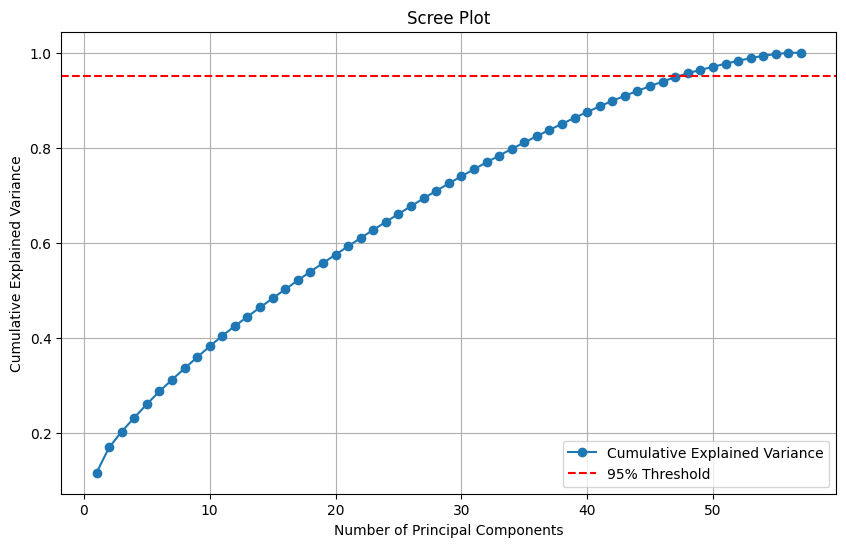

Optimal number of components: 48

Running for n = 0.25:
Class distribution before augmentation: Counter({0: 2788, 1: 613})
Reidentification Risk: 0.0995
Membership Inference Attack Accuracy: 0.8217
Class distribution after augmentation: Counter({0: 2788, 1: 766})


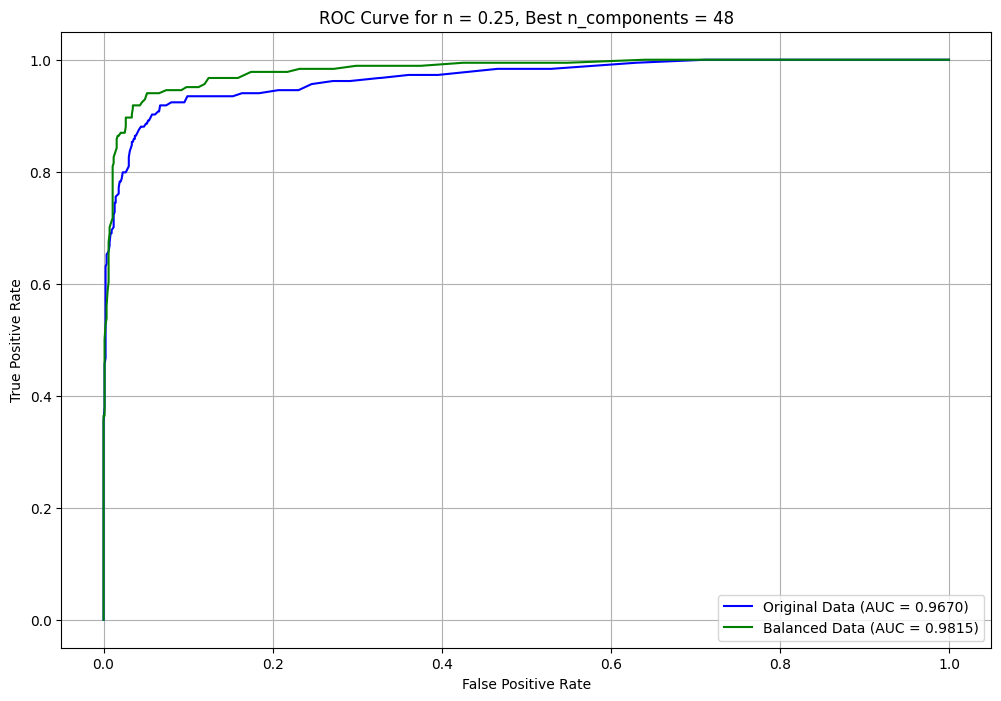


Results:
Recall (Original Data): 0.7989
Recall (Balanced Data): 0.8859

Classification Report (Original Data):
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       837
           1       0.89      0.80      0.84       184

    accuracy                           0.95      1021
   macro avg       0.92      0.89      0.90      1021
weighted avg       0.94      0.95      0.94      1021


Classification Report (Balanced Data):
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       837
           1       0.88      0.89      0.88       184

    accuracy                           0.96      1021
   macro avg       0.93      0.93      0.93      1021
weighted avg       0.96      0.96      0.96      1021


Running for n = 0.5:
Class distribution before augmentation: Counter({0: 2788, 1: 613})
Reidentification Risk: 0.1550
Membership Inference Attack Accuracy: 0.7500
Class distribution after augme

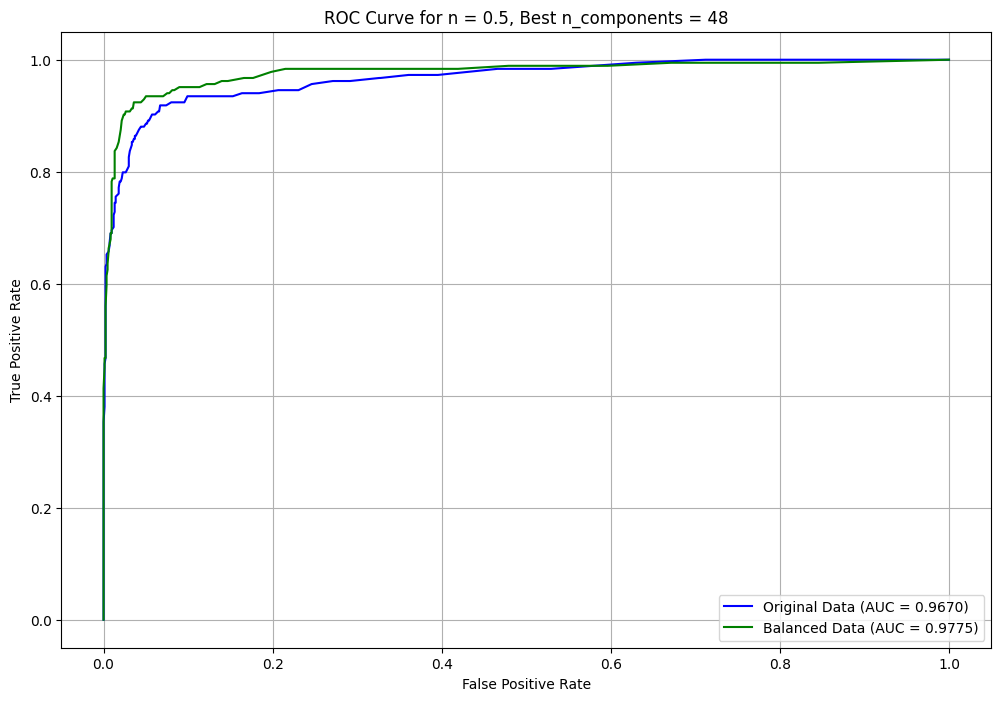


Results:
Recall (Original Data): 0.7989
Recall (Balanced Data): 0.9076

Classification Report (Original Data):
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       837
           1       0.89      0.80      0.84       184

    accuracy                           0.95      1021
   macro avg       0.92      0.89      0.90      1021
weighted avg       0.94      0.95      0.94      1021


Classification Report (Balanced Data):
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       837
           1       0.88      0.91      0.90       184

    accuracy                           0.96      1021
   macro avg       0.93      0.94      0.94      1021
weighted avg       0.96      0.96      0.96      1021


Running for n = 0.75:
Class distribution before augmentation: Counter({0: 2788, 1: 613})
Reidentification Risk: 0.2007
Membership Inference Attack Accuracy: 0.7422
Class distribution after augm

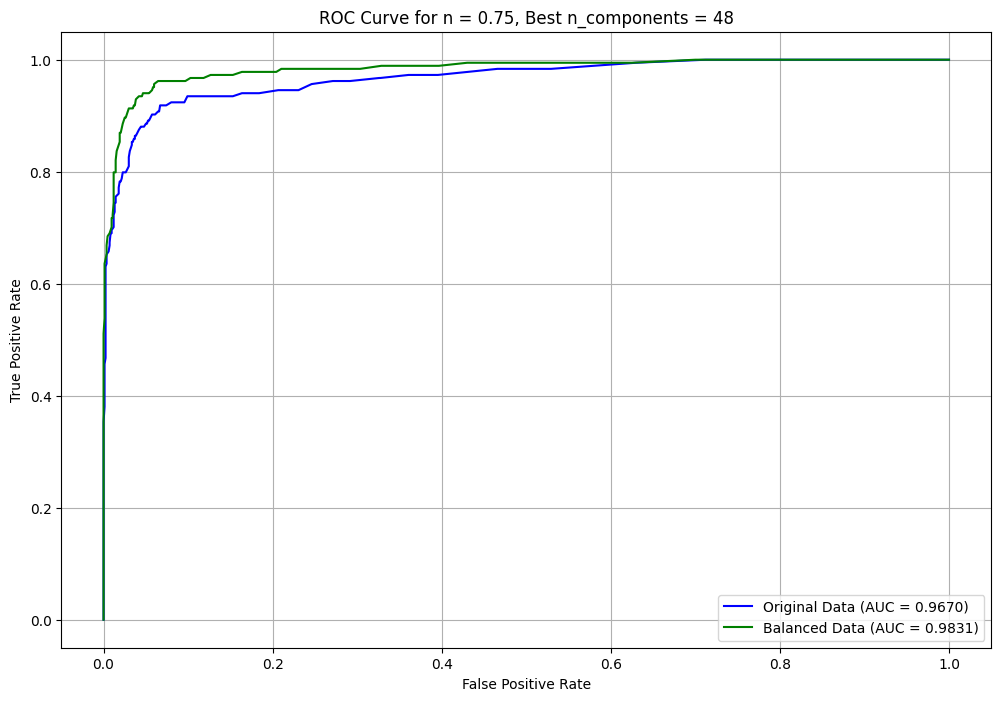


Results:
Recall (Original Data): 0.7989
Recall (Balanced Data): 0.9185

Classification Report (Original Data):
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       837
           1       0.89      0.80      0.84       184

    accuracy                           0.95      1021
   macro avg       0.92      0.89      0.90      1021
weighted avg       0.94      0.95      0.94      1021


Classification Report (Balanced Data):
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       837
           1       0.85      0.92      0.88       184

    accuracy                           0.96      1021
   macro avg       0.92      0.94      0.93      1021
weighted avg       0.96      0.96      0.96      1021


Running for n = 1:
Class distribution before augmentation: Counter({0: 2788, 1: 613})
Reidentification Risk: 0.2529
Membership Inference Attack Accuracy: 0.7636
Class distribution after augment

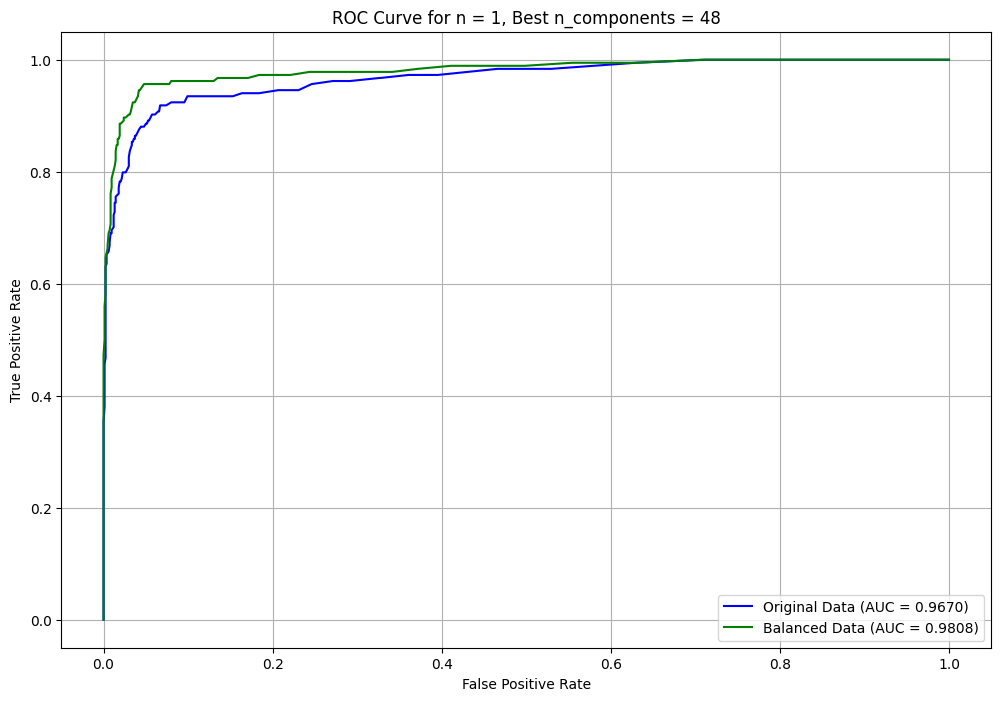


Results:
Recall (Original Data): 0.7989
Recall (Balanced Data): 0.9076

Classification Report (Original Data):
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       837
           1       0.89      0.80      0.84       184

    accuracy                           0.95      1021
   macro avg       0.92      0.89      0.90      1021
weighted avg       0.94      0.95      0.94      1021


Classification Report (Balanced Data):
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       837
           1       0.86      0.91      0.88       184

    accuracy                           0.96      1021
   macro avg       0.92      0.94      0.93      1021
weighted avg       0.96      0.96      0.96      1021


Running for n = 1.25:
Class distribution before augmentation: Counter({0: 2788, 1: 613})
Reidentification Risk: 0.2936
Membership Inference Attack Accuracy: 0.7850
Class distribution after augm

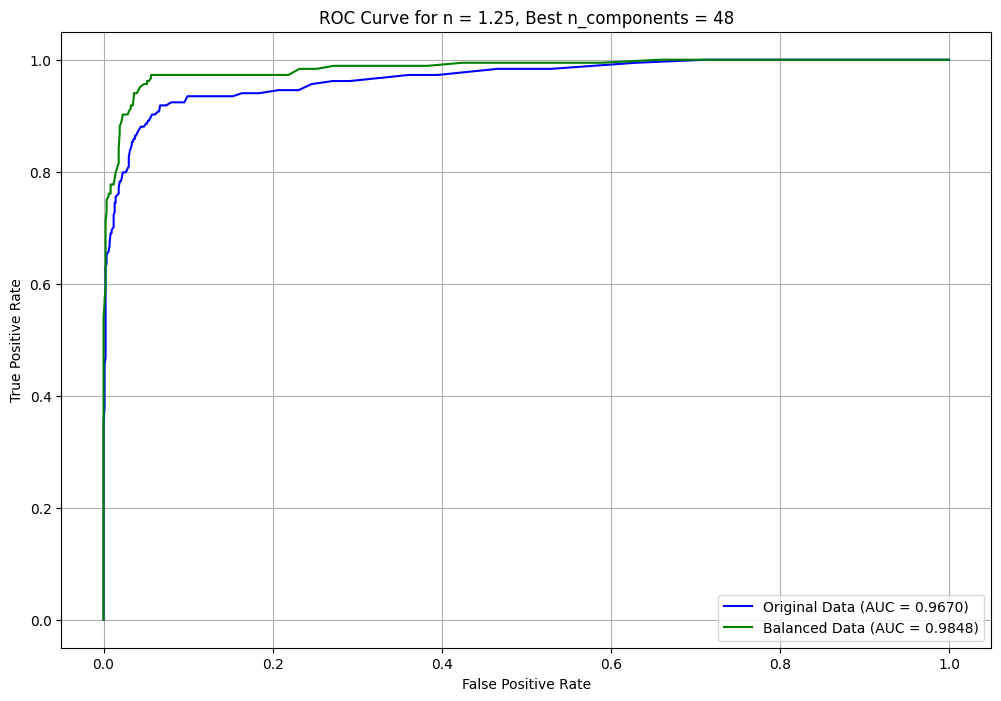


Results:
Recall (Original Data): 0.7989
Recall (Balanced Data): 0.9348

Classification Report (Original Data):
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       837
           1       0.89      0.80      0.84       184

    accuracy                           0.95      1021
   macro avg       0.92      0.89      0.90      1021
weighted avg       0.94      0.95      0.94      1021


Classification Report (Balanced Data):
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       837
           1       0.85      0.93      0.89       184

    accuracy                           0.96      1021
   macro avg       0.92      0.95      0.93      1021
weighted avg       0.96      0.96      0.96      1021


Running for n = 1.5:
Class distribution before augmentation: Counter({0: 2788, 1: 613})
Reidentification Risk: 0.3067
Membership Inference Attack Accuracy: 0.7891
Class distribution after augme

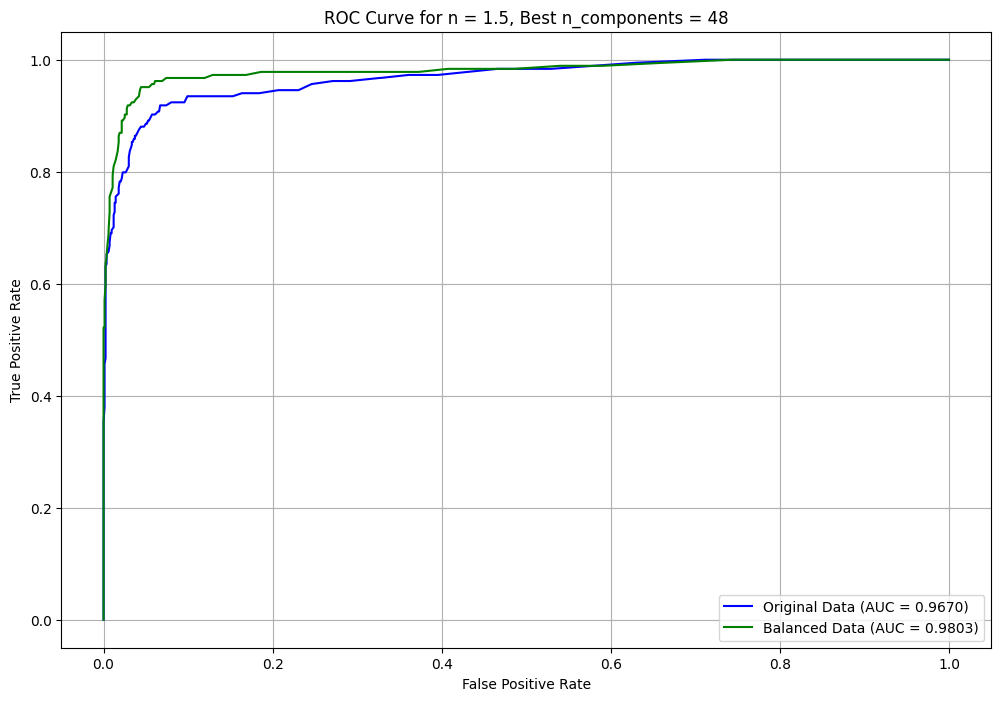


Results:
Recall (Original Data): 0.7989
Recall (Balanced Data): 0.9239

Classification Report (Original Data):
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       837
           1       0.89      0.80      0.84       184

    accuracy                           0.95      1021
   macro avg       0.92      0.89      0.90      1021
weighted avg       0.94      0.95      0.94      1021


Classification Report (Balanced Data):
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       837
           1       0.86      0.92      0.89       184

    accuracy                           0.96      1021
   macro avg       0.92      0.95      0.93      1021
weighted avg       0.96      0.96      0.96      1021


Running for n = 1.75:
Class distribution before augmentation: Counter({0: 2788, 1: 613})
Reidentification Risk: 0.3148
Membership Inference Attack Accuracy: 0.7727
Class distribution after augm

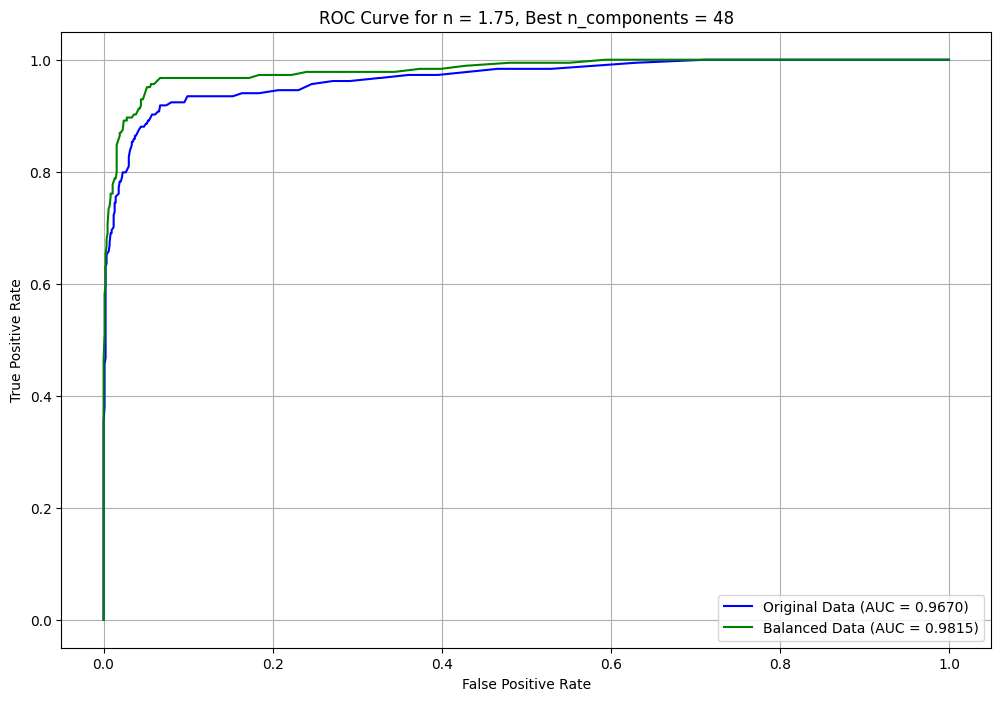


Results:
Recall (Original Data): 0.7989
Recall (Balanced Data): 0.9293

Classification Report (Original Data):
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       837
           1       0.89      0.80      0.84       184

    accuracy                           0.95      1021
   macro avg       0.92      0.89      0.90      1021
weighted avg       0.94      0.95      0.94      1021


Classification Report (Balanced Data):
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       837
           1       0.82      0.93      0.87       184

    accuracy                           0.95      1021
   macro avg       0.90      0.94      0.92      1021
weighted avg       0.95      0.95      0.95      1021


Running for n = 2.0:
Class distribution before augmentation: Counter({0: 2788, 1: 613})
Reidentification Risk: 0.3214
Membership Inference Attack Accuracy: 0.7717
Class distribution after augme

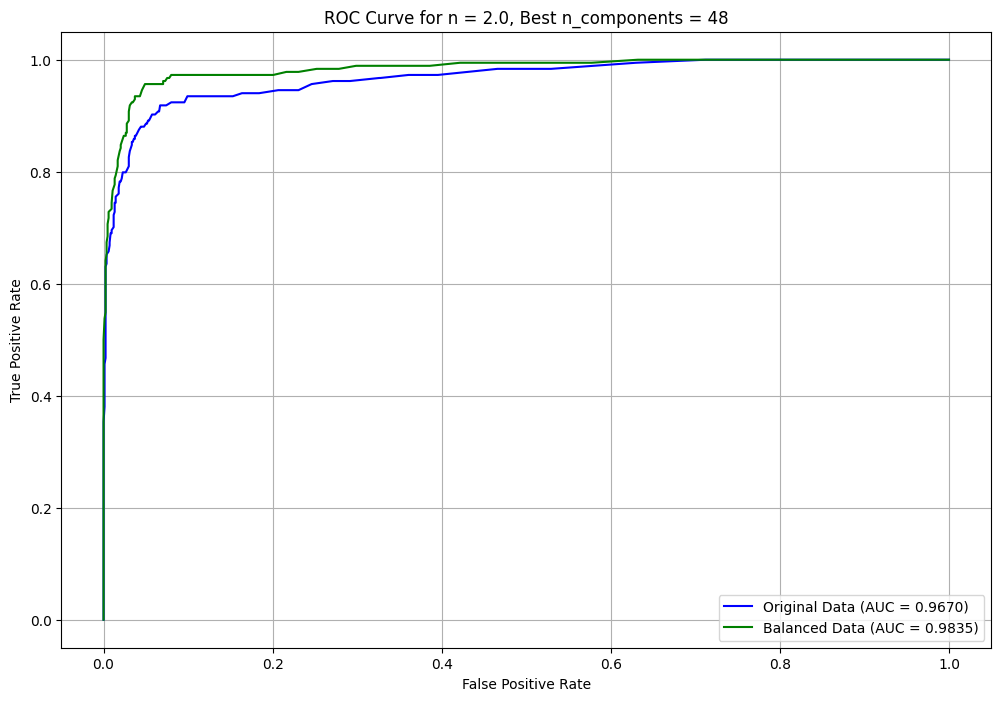


Results:
Recall (Original Data): 0.7989
Recall (Balanced Data): 0.9348

Classification Report (Original Data):
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       837
           1       0.89      0.80      0.84       184

    accuracy                           0.95      1021
   macro avg       0.92      0.89      0.90      1021
weighted avg       0.94      0.95      0.94      1021


Classification Report (Balanced Data):
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       837
           1       0.85      0.93      0.89       184

    accuracy                           0.96      1021
   macro avg       0.92      0.95      0.93      1021
weighted avg       0.96      0.96      0.96      1021


Running for n = 2.25:
Class distribution before augmentation: Counter({0: 2788, 1: 613})
Reidentification Risk: 0.3328
Membership Inference Attack Accuracy: 0.8077
Class distribution after augm

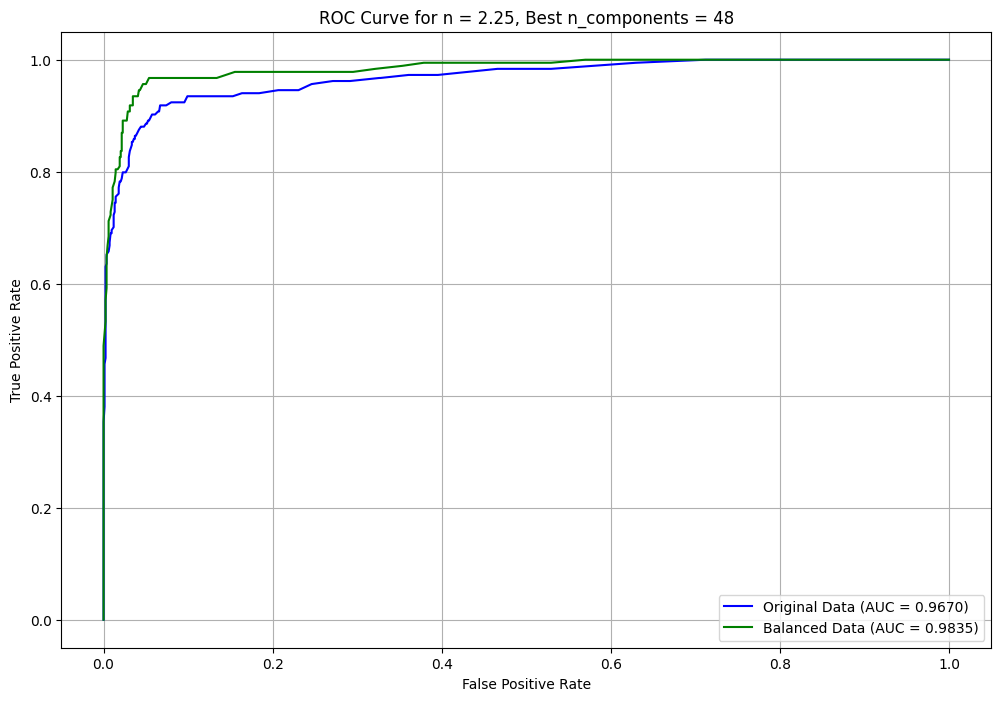


Results:
Recall (Original Data): 0.7989
Recall (Balanced Data): 0.9348

Classification Report (Original Data):
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       837
           1       0.89      0.80      0.84       184

    accuracy                           0.95      1021
   macro avg       0.92      0.89      0.90      1021
weighted avg       0.94      0.95      0.94      1021


Classification Report (Balanced Data):
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       837
           1       0.84      0.93      0.89       184

    accuracy                           0.96      1021
   macro avg       0.91      0.95      0.93      1021
weighted avg       0.96      0.96      0.96      1021


Running for n = 2.5:
Class distribution before augmentation: Counter({0: 2788, 1: 613})
Reidentification Risk: 0.3458
Membership Inference Attack Accuracy: 0.8230
Class distribution after augme

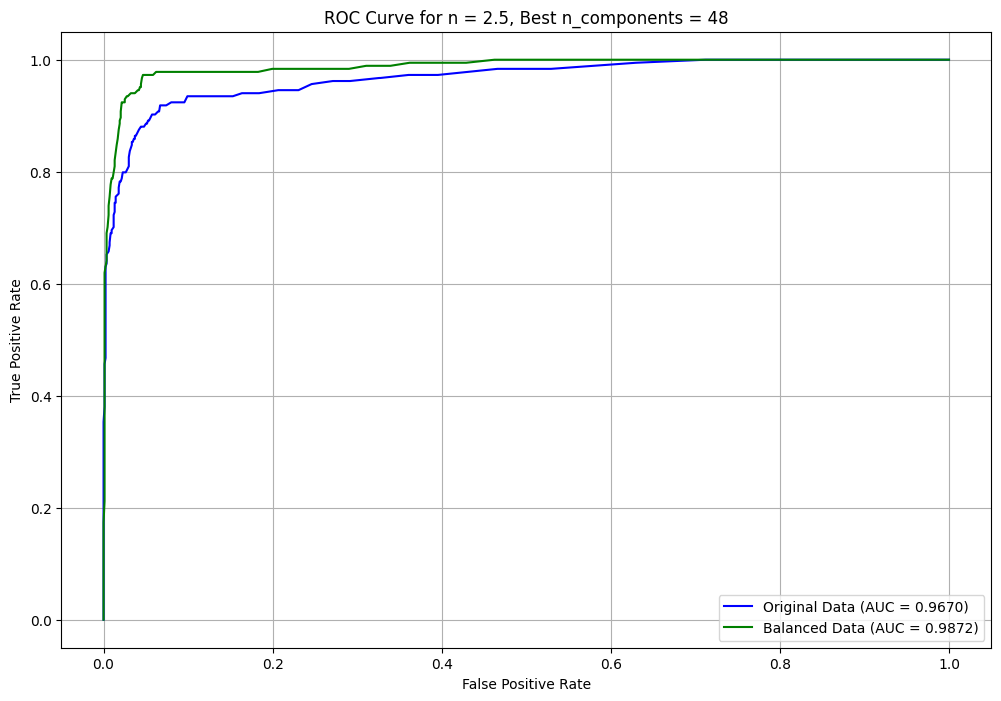


Results:
Recall (Original Data): 0.7989
Recall (Balanced Data): 0.9565

Classification Report (Original Data):
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       837
           1       0.89      0.80      0.84       184

    accuracy                           0.95      1021
   macro avg       0.92      0.89      0.90      1021
weighted avg       0.94      0.95      0.94      1021


Classification Report (Balanced Data):
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       837
           1       0.83      0.96      0.89       184

    accuracy                           0.96      1021
   macro avg       0.91      0.96      0.93      1021
weighted avg       0.96      0.96      0.96      1021


Running for n = 2.75:
Class distribution before augmentation: Counter({0: 2788, 1: 613})
Reidentification Risk: 0.3654
Membership Inference Attack Accuracy: 0.8275
Class distribution after augm

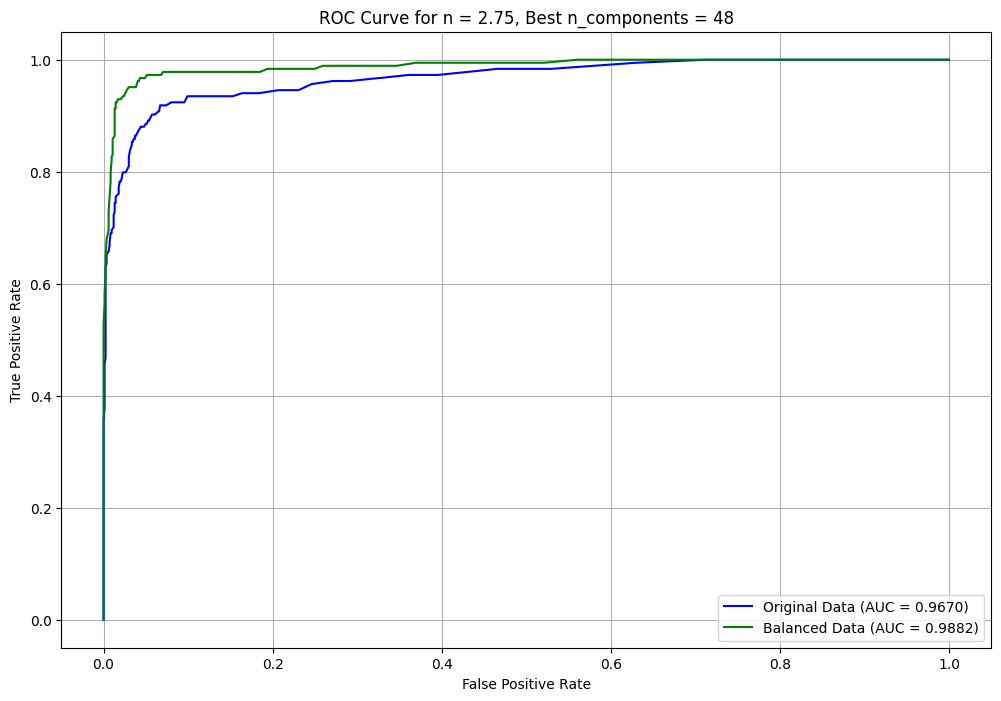


Results:
Recall (Original Data): 0.7989
Recall (Balanced Data): 0.9674

Classification Report (Original Data):
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       837
           1       0.89      0.80      0.84       184

    accuracy                           0.95      1021
   macro avg       0.92      0.89      0.90      1021
weighted avg       0.94      0.95      0.94      1021


Classification Report (Balanced Data):
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       837
           1       0.81      0.97      0.88       184

    accuracy                           0.95      1021
   macro avg       0.90      0.96      0.93      1021
weighted avg       0.96      0.95      0.96      1021


Running for n = 3:
Class distribution before augmentation: Counter({0: 2788, 1: 613})
Reidentification Risk: 0.3736
Membership Inference Attack Accuracy: 0.8234
Class distribution after augment

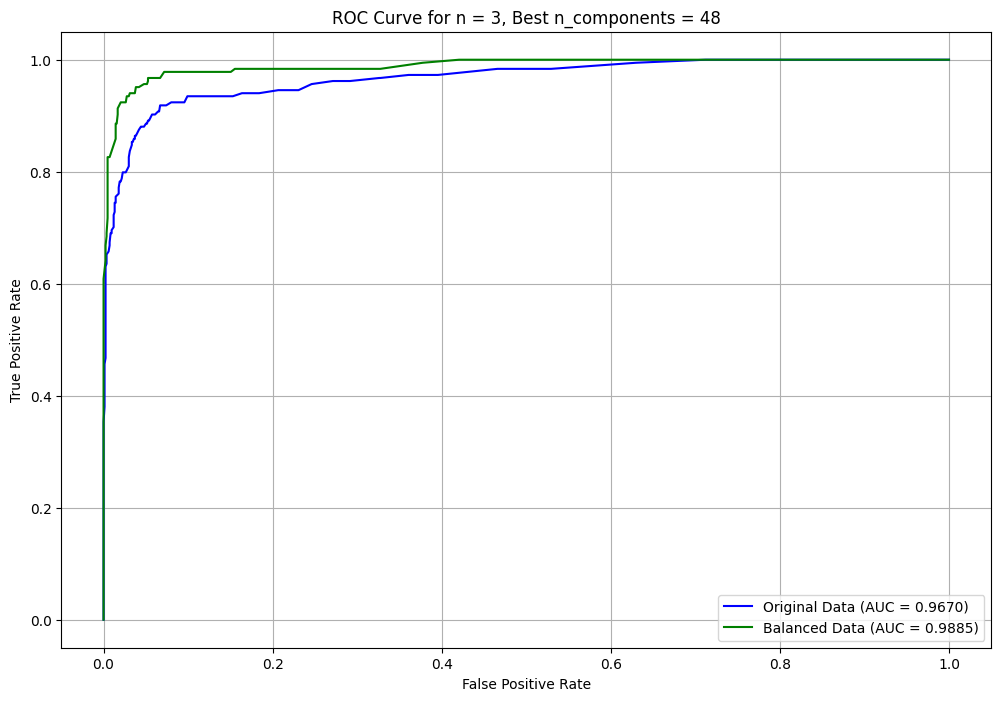


Results:
Recall (Original Data): 0.7989
Recall (Balanced Data): 0.9565

Classification Report (Original Data):
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       837
           1       0.89      0.80      0.84       184

    accuracy                           0.95      1021
   macro avg       0.92      0.89      0.90      1021
weighted avg       0.94      0.95      0.94      1021


Classification Report (Balanced Data):
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       837
           1       0.81      0.96      0.88       184

    accuracy                           0.95      1021
   macro avg       0.90      0.95      0.93      1021
weighted avg       0.96      0.95      0.95      1021



In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, auc, recall_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from ForestDiffusion import ForestDiffusionModel
import matplotlib.pyplot as plt
from collections import Counter

# Function to calculate Reidentification Risk
def calculate_reidentification_risk(original, synthetic):
    """
    Calculate reidentification risk based on similarity between original and synthetic data.
    """
    similarity_matrix = cosine_similarity(original, synthetic)
    max_similarities = np.max(similarity_matrix, axis=1)
    reidentification_risk = np.mean(max_similarities > 0.9)  # Threshold for reidentification
    return reidentification_risk

# Function to perform Membership Inference Attack
def membership_inference_attack(original, synthetic):
    """
    Perform membership inference attack on synthetic data.
    """
    # Combine original and synthetic datasets
    X_combined = np.vstack([original, synthetic])
    y_combined = np.hstack([np.ones(original.shape[0]), np.zeros(synthetic.shape[0])])

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.3, random_state=42)

    # Train a classifier to predict membership
    attack_model = RandomForestClassifier(random_state=42)
    attack_model.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = attack_model.predict(X_test)
    attack_accuracy = np.mean(y_pred == y_test)
    return attack_accuracy

# Step 1: Load the data
data = pd.read_csv('reduced_spambase.csv')
X = data.iloc[:, :-1]  # Features (assuming target is the last column)
y = data.iloc[:, -1]  # Target

# Step 2: Standardize the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Apply PCA and determine the optimal number of components using the Scree Method
pca = PCA()
pca.fit(X_scaled)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Scree Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, marker='o', label='Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Threshold')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.legend()
plt.grid()
plt.show()

# Find the optimal number of components
best_n_components = np.argmax(cumulative_variance_ratio >= 0.95) + 1
print(f"Optimal number of components: {best_n_components}")

# Step 4: Reduce dimensionality using the optimal number of components
pca = PCA(n_components=best_n_components)
X_reduced = pca.fit_transform(X_scaled)

# Define a list of values for n
n_values = [0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3]

for n in n_values:
    print(f"\nRunning for n = {n}:")

    # Step 5: Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=42, stratify=y)

    # Step 6: Train a Random Forest classifier on the original dataset
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train, y_train)

    # Predict and evaluate recall on the original test set
    y_pred = rf.predict(X_test)
    recall_original = recall_score(y_test, y_pred)
    classification_report_original = classification_report(y_test, y_pred)

    # Calculate ROC curve and AUC for original data
    fpr_original, tpr_original, _ = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
    auc_original = auc(fpr_original, tpr_original)

    # Step 7: Identify the minority class
    class_counts = Counter(y)
    minority_class = min(class_counts, key=class_counts.get)
    print("Class distribution before augmentation:", class_counts)

    # Step 8: Use ForestDiffusionModel to generate synthetic samples for the minority class
    X_minority_reduced = X_reduced[y == minority_class]

    forest_model = ForestDiffusionModel(
        X_minority_reduced,
        label_y=None,
        n_t=50,
        duplicate_K=100,
        bin_indexes=[],       # No binary columns in latent space
        cat_indexes=[],       # No categorical columns in latent space
        int_indexes=[],       # No integer columns in latent space
        diffusion_type='flow',
        n_jobs=-1
    )

    # Generate synthetic samples in latent space
    num_samples_to_generate = round(len(X_minority_reduced) * n)
    generated_samples_reduced = forest_model.generate(batch_size=num_samples_to_generate)

    # Step 9: Evaluate privacy metrics
    reidentification_risk = calculate_reidentification_risk(X_minority_reduced, generated_samples_reduced)
    print(f"Reidentification Risk: {reidentification_risk:.4f}")

    membership_attack_accuracy = membership_inference_attack(X_minority_reduced, generated_samples_reduced)
    print(f"Membership Inference Attack Accuracy: {membership_attack_accuracy:.4f}")

    # Step 10: Add synthetic data to the original data in latent space
    X_balanced_reduced = np.vstack([X_reduced, generated_samples_reduced])
    y_balanced = np.hstack([y, [minority_class] * len(generated_samples_reduced)])

    class_counts_after = Counter(y_balanced)
    print("Class distribution after augmentation:", class_counts_after)

    # Step 11: Train-test split and train Random Forest on the balanced dataset
    X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(
        X_balanced_reduced, y_balanced, test_size=0.3, random_state=42, stratify=y_balanced)

    rf_bal = RandomForestClassifier(random_state=42)
    rf_bal.fit(X_train_balanced, y_train_balanced)

    # Predict and evaluate recall on the balanced test set
    y_pred_balanced = rf_bal.predict(X_test)
    recall_balanced = recall_score(y_test, y_pred_balanced)
    classification_report_balanced = classification_report(y_test, y_pred_balanced)

    # Calculate ROC curve and AUC for balanced data
    fpr_balanced, tpr_balanced, _ = roc_curve(y_test, rf_bal.predict_proba(X_test)[:, 1])
    auc_balanced = auc(fpr_balanced, tpr_balanced)

    # Step 12: Plot the ROC curves
    plt.figure(figsize=(12, 8))
    plt.plot(fpr_original, tpr_original, label=f'Original Data (AUC = {auc_original:.4f})', color='blue')
    plt.plot(fpr_balanced, tpr_balanced, label=f'Balanced Data (AUC = {auc_balanced:.4f})', color='green')
    plt.title(f"ROC Curve for n = {n}, Best n_components = {best_n_components}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Output the results
    print("\nResults:")
    print(f"Recall (Original Data): {recall_original:.4f}")
    print(f"Recall (Balanced Data): {recall_balanced:.4f}")
    print("\nClassification Report (Original Data):")
    print(classification_report_original)
    print("\nClassification Report (Balanced Data):")
    print(classification_report_balanced)


# Feature Selection

In [3]:
# Feature Importance Calculation
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, recall_score, f1_score
from ForestDiffusion import ForestDiffusionModel

# Load the data
data = pd.read_csv('reduced_spambase.csv')
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Class distribution before augmentation
unique, counts = np.unique(y, return_counts=True)
class_dist_before = dict(zip(unique, counts))
print(f"Class distribution before augmentation: {class_dist_before}")

# Perform feature selection using Random Forest
feature_selector = RandomForestClassifier(random_state=42)
feature_selector.fit(X, y)

# Get feature importances
importances = feature_selector.feature_importances_
features = data.columns[:-1]  # Extract feature names (excluding the target column)

# List features in descending order of importance
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\nFeatures sorted by importance:")
print(feature_importance_df)


Class distribution before augmentation: {0: 2788, 1: 613}

Features sorted by importance:
                       Feature  Importance
51                 char_freq_!    0.121521
6             word_freq_remove    0.098118
52                 char_freq_$    0.096803
15              word_freq_free    0.072265
54  capital_run_length_average    0.070711
55  capital_run_length_longest    0.042972
20              word_freq_your    0.042690
56    capital_run_length_total    0.041927
22               word_freq_000    0.034402
23             word_freq_money    0.033194
24                word_freq_hp    0.029200
18               word_freq_you    0.027568
4                word_freq_our    0.024445
7           word_freq_internet    0.021634
2                word_freq_all    0.015824
49                 char_freq_(    0.013649
17             word_freq_email    0.013093
19            word_freq_credit    0.013074
36              word_freq_1999    0.012373
16          word_freq_business    0.012168
11     

# FD_FS

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, recall_score, f1_score
from ForestDiffusion import ForestDiffusionModel

# Load the data
data = pd.read_csv('reduced_spambase.csv')
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Class distribution before augmentation
unique, counts = np.unique(y, return_counts=True)
class_dist_before = dict(zip(unique, counts))
print(f"Class distribution before augmentation: {class_dist_before}")

# Perform feature selection using Random Forest
feature_selector = RandomForestClassifier(random_state=42)
feature_selector.fit(X, y)

# Get feature importances
importances = feature_selector.feature_importances_
features = data.columns[:-1]  # Extract feature names (excluding the target column)

# Set a fixed threshold for feature importance (e.g., 0.1)
threshold = 0.0097

# Select features meeting the threshold
selected_threshold = importances >= threshold

# Get features above the threshold
selected_features = np.where(selected_threshold)[0]
print(f"\nFeatures selected with importance >= {threshold}:")
for i in selected_features:
    print(f"Feature: {features[i]}, Importance: {importances[i]:.4f}")

# Reduce dataset to selected features
X_selected = X[:, selected_features]
X_minority = X_selected[y == 1]

# Train-test split for original data with selected features
X_train_orig, X_test, y_train_orig, y_test = train_test_split(
    X_selected, y, test_size=0.3, random_state=42, stratify=y
)

# Train a Random Forest on the original data with selected features
clf_orig = RandomForestClassifier(random_state=42)
clf_orig.fit(X_train_orig, y_train_orig)

# Predict and calculate recall and F1 score on original data
y_pred_orig = clf_orig.predict(X_test)
recall_orig = recall_score(y_test, y_pred_orig)
f1_orig = f1_score(y_test, y_pred_orig)
print(f"\nRecall score (original data): {recall_orig:.4f}")
print(f"F1 score (original data): {f1_orig:.4f}")

# Initialize Forest Diffusion Model for data augmentation
forest_model = ForestDiffusionModel(
    X_minority, label_y=None, n_t=50, duplicate_K=100,
    bin_indexes=[], cat_indexes=[], int_indexes=[],
    diffusion_type='flow', n_jobs=-1
)

# Loop through different augmentation levels
n_values = [0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3]  # Define values of n to generate different amounts of synthetic data

for n in n_values:
    print(f"\nGenerating data with n = {n}...")

    # Generate synthetic data
    X_minority_fake = forest_model.generate(batch_size=round(len(X_minority) * n))

    # Combine the synthetic data with original data
    X_balanced = np.concatenate((X_selected, X_minority_fake), axis=0)
    y_balanced = np.concatenate((y, np.ones(X_minority_fake.shape[0])), axis=0)

    # Class distribution after augmentation
    unique, counts = np.unique(y_balanced, return_counts=True)
    class_dist_after = dict(zip(unique, counts))
    print(f"Class distribution after augmentation: {class_dist_after}")

    # Train-test split for augmented data
    X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(
        X_balanced, y_balanced, test_size=0.3, random_state=42, stratify=y_balanced
    )

    # Train a Random Forest on the augmented data
    clf_bal = RandomForestClassifier(random_state=42)
    clf_bal.fit(X_train_bal, y_train_bal)

    # Predict and calculate recall and F1 score on augmented data
    y_pred_bal = clf_bal.predict(X_test)
    recall_bal = recall_score(y_test, y_pred_bal)
    f1_bal = f1_score(y_test, y_pred_bal)

    print(f"\nResults for n = {n}:")
    print(f"Recall score: {recall_bal:.4f}")
    print(f"F1 score: {f1_bal:.4f}")

    # Print classification report
    print("\nClassification Report:\n", classification_report(y_test, y_pred_bal))


Class distribution before augmentation: {0: 2788, 1: 613}

Features selected with importance >= 0.0097:
Feature: word_freq_address, Importance: 0.0097
Feature: word_freq_all, Importance: 0.0158
Feature: word_freq_our, Importance: 0.0244
Feature: word_freq_remove, Importance: 0.0981
Feature: word_freq_internet, Importance: 0.0216
Feature: word_freq_mail, Importance: 0.0098
Feature: word_freq_receive, Importance: 0.0115
Feature: word_freq_will, Importance: 0.0117
Feature: word_freq_free, Importance: 0.0723
Feature: word_freq_business, Importance: 0.0122
Feature: word_freq_email, Importance: 0.0131
Feature: word_freq_you, Importance: 0.0276
Feature: word_freq_credit, Importance: 0.0131
Feature: word_freq_your, Importance: 0.0427
Feature: word_freq_000, Importance: 0.0344
Feature: word_freq_money, Importance: 0.0332
Feature: word_freq_hp, Importance: 0.0292
Feature: word_freq_george, Importance: 0.0116
Feature: word_freq_1999, Importance: 0.0124
Feature: word_freq_edu, Importance: 0.0115
F

# FD_PCA_FS


Features selected with importance >= 0.0097:
word_freq_address: 0.0097
word_freq_all: 0.0158
word_freq_our: 0.0244
word_freq_remove: 0.0981
word_freq_internet: 0.0216
word_freq_mail: 0.0098
word_freq_receive: 0.0115
word_freq_will: 0.0117
word_freq_free: 0.0723
word_freq_business: 0.0122
word_freq_email: 0.0131
word_freq_you: 0.0276
word_freq_credit: 0.0131
word_freq_your: 0.0427
word_freq_000: 0.0344
word_freq_money: 0.0332
word_freq_hp: 0.0292
word_freq_george: 0.0116
word_freq_1999: 0.0124
word_freq_edu: 0.0115
char_freq_(: 0.0136
char_freq_!: 0.1215
char_freq_$: 0.0968
capital_run_length_average: 0.0707
capital_run_length_longest: 0.0430
capital_run_length_total: 0.0419


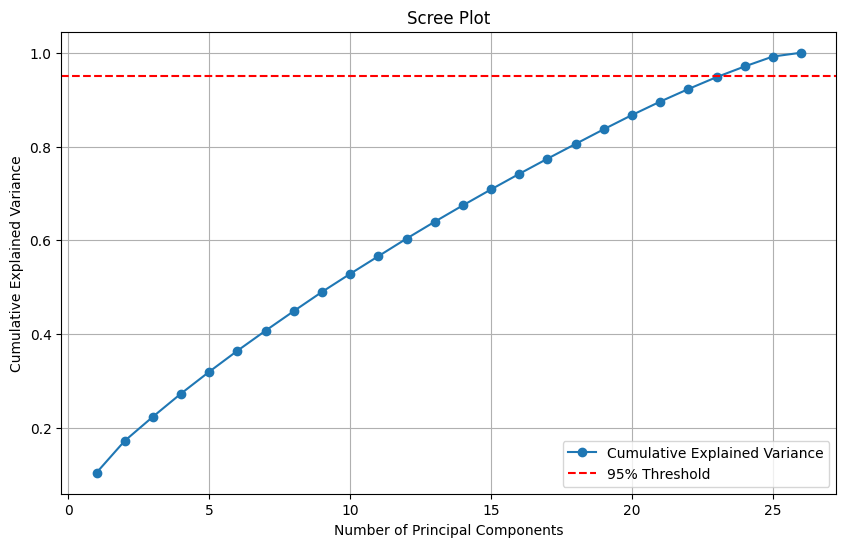

Optimal number of components: 24
Class distribution before augmentation: Counter({0: 2788, 1: 613})

Generating data with n = 0.25...
Class distribution after augmentation: Counter({0: 2788, 1: 766})


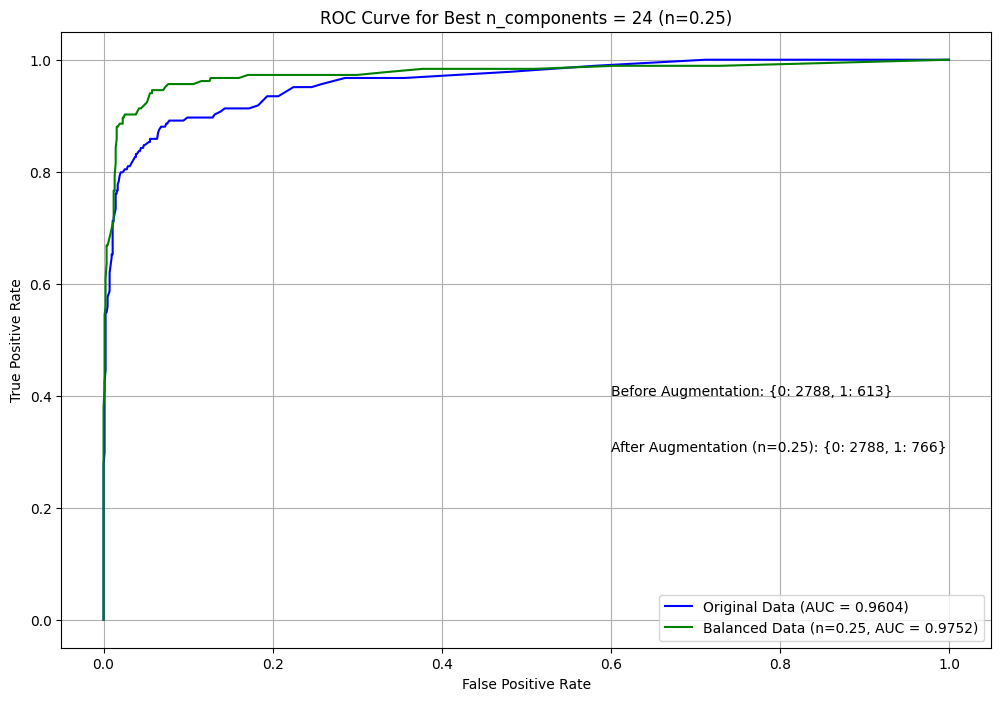


Results:
Recall (Original Data): 0.7989
Recall (Balanced Data, n=0.25): 0.9022

Classification Report (Original Data):
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       837
           1       0.89      0.80      0.84       184

    accuracy                           0.95      1021
   macro avg       0.92      0.89      0.90      1021
weighted avg       0.94      0.95      0.94      1021


Classification Report (Balanced Data, n=0.25):
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       837
           1       0.88      0.90      0.89       184

    accuracy                           0.96      1021
   macro avg       0.93      0.94      0.93      1021
weighted avg       0.96      0.96      0.96      1021


Generating data with n = 0.5...
Class distribution after augmentation: Counter({0: 2788, 1: 919})


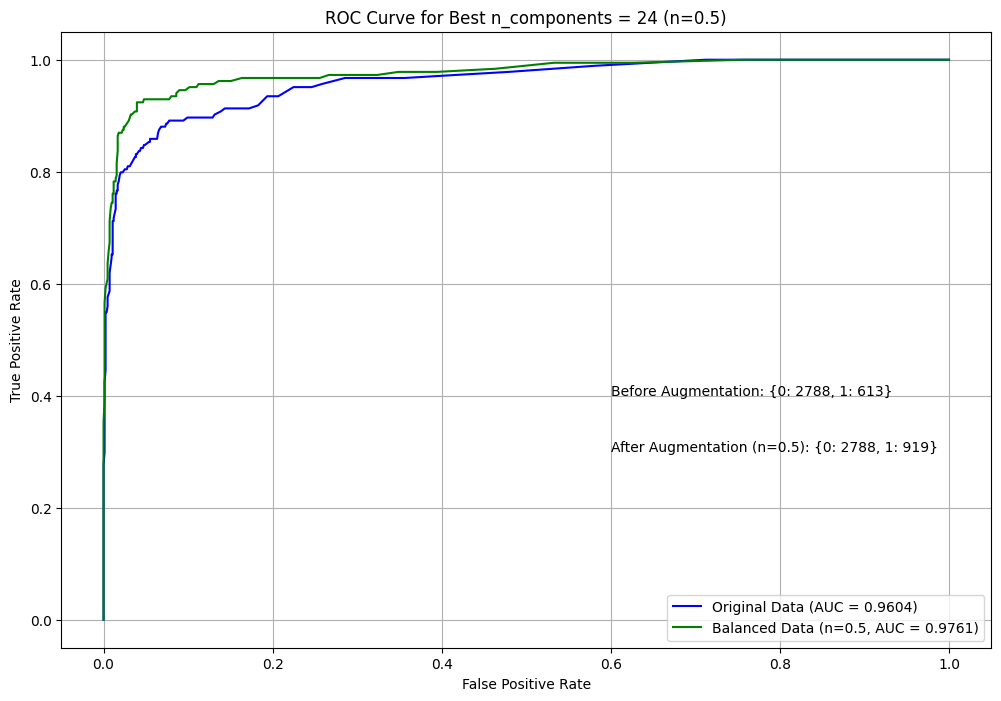


Results:
Recall (Original Data): 0.7989
Recall (Balanced Data, n=0.5): 0.9076

Classification Report (Original Data):
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       837
           1       0.89      0.80      0.84       184

    accuracy                           0.95      1021
   macro avg       0.92      0.89      0.90      1021
weighted avg       0.94      0.95      0.94      1021


Classification Report (Balanced Data, n=0.5):
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       837
           1       0.84      0.91      0.87       184

    accuracy                           0.95      1021
   macro avg       0.91      0.94      0.92      1021
weighted avg       0.95      0.95      0.95      1021


Generating data with n = 0.75...
Class distribution after augmentation: Counter({0: 2788, 1: 1073})


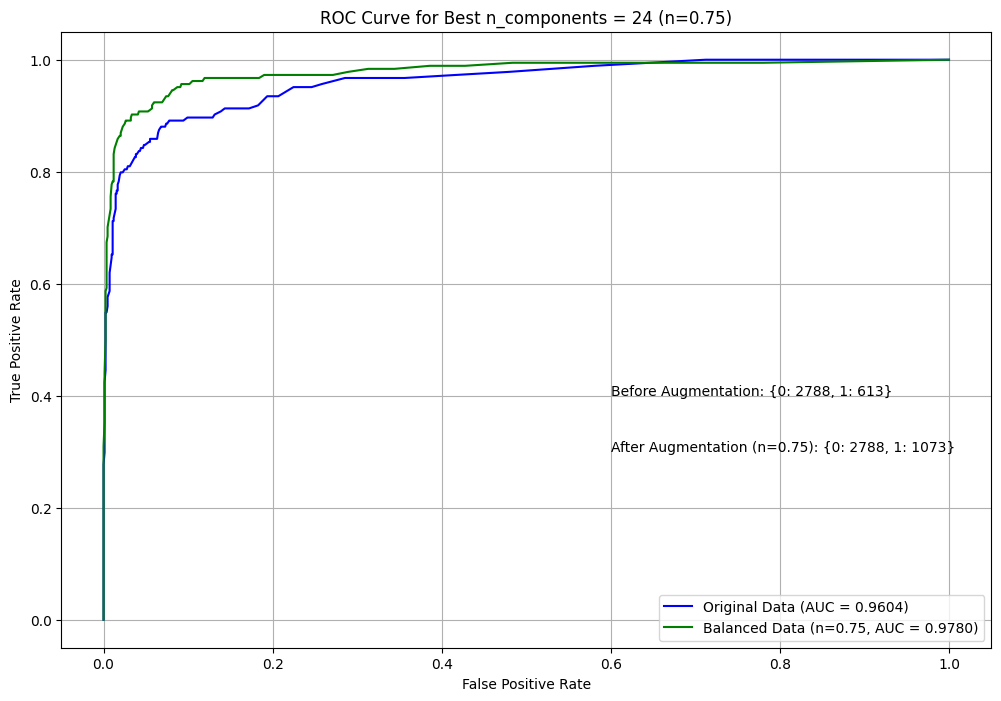


Results:
Recall (Original Data): 0.7989
Recall (Balanced Data, n=0.75): 0.9022

Classification Report (Original Data):
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       837
           1       0.89      0.80      0.84       184

    accuracy                           0.95      1021
   macro avg       0.92      0.89      0.90      1021
weighted avg       0.94      0.95      0.94      1021


Classification Report (Balanced Data, n=0.75):
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       837
           1       0.84      0.90      0.87       184

    accuracy                           0.95      1021
   macro avg       0.91      0.93      0.92      1021
weighted avg       0.95      0.95      0.95      1021


Generating data with n = 1...
Class distribution after augmentation: Counter({0: 2788, 1: 1226})


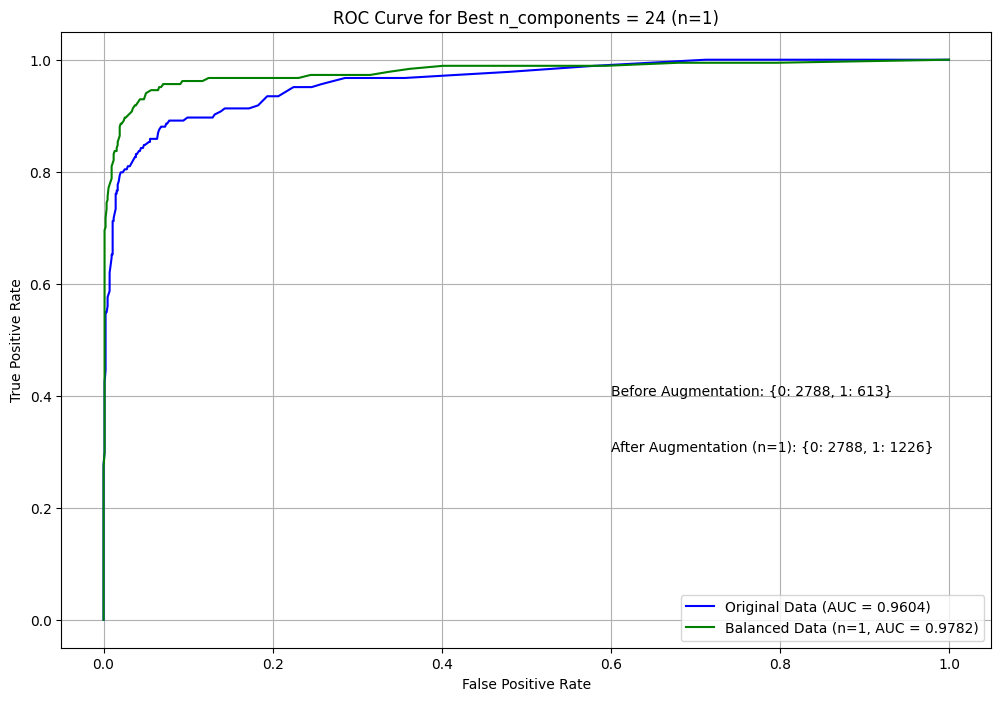


Results:
Recall (Original Data): 0.7989
Recall (Balanced Data, n=1): 0.9239

Classification Report (Original Data):
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       837
           1       0.89      0.80      0.84       184

    accuracy                           0.95      1021
   macro avg       0.92      0.89      0.90      1021
weighted avg       0.94      0.95      0.94      1021


Classification Report (Balanced Data, n=1):
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       837
           1       0.83      0.92      0.88       184

    accuracy                           0.95      1021
   macro avg       0.91      0.94      0.92      1021
weighted avg       0.96      0.95      0.95      1021


Generating data with n = 1.25...
Class distribution after augmentation: Counter({0: 2788, 1: 1379})


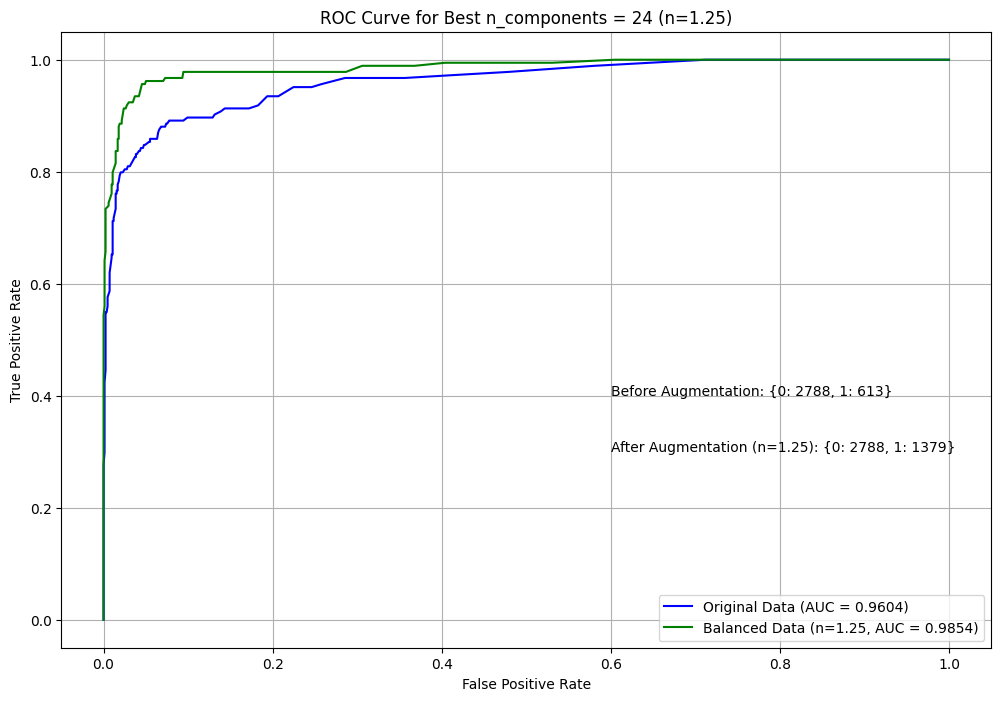


Results:
Recall (Original Data): 0.7989
Recall (Balanced Data, n=1.25): 0.9565

Classification Report (Original Data):
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       837
           1       0.89      0.80      0.84       184

    accuracy                           0.95      1021
   macro avg       0.92      0.89      0.90      1021
weighted avg       0.94      0.95      0.94      1021


Classification Report (Balanced Data, n=1.25):
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       837
           1       0.82      0.96      0.88       184

    accuracy                           0.95      1021
   macro avg       0.91      0.96      0.93      1021
weighted avg       0.96      0.95      0.96      1021


Generating data with n = 1.5...
Class distribution after augmentation: Counter({0: 2788, 1: 1533})


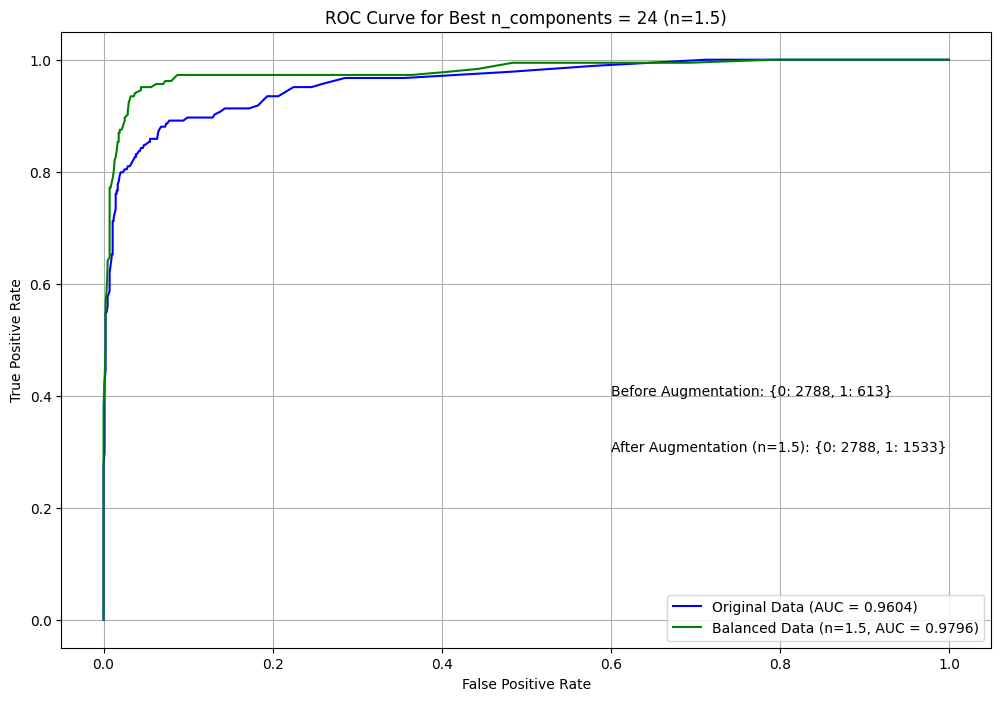


Results:
Recall (Original Data): 0.7989
Recall (Balanced Data, n=1.5): 0.9511

Classification Report (Original Data):
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       837
           1       0.89      0.80      0.84       184

    accuracy                           0.95      1021
   macro avg       0.92      0.89      0.90      1021
weighted avg       0.94      0.95      0.94      1021


Classification Report (Balanced Data, n=1.5):
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       837
           1       0.81      0.95      0.87       184

    accuracy                           0.95      1021
   macro avg       0.90      0.95      0.92      1021
weighted avg       0.96      0.95      0.95      1021


Generating data with n = 1.75...
Class distribution after augmentation: Counter({0: 2788, 1: 1686})


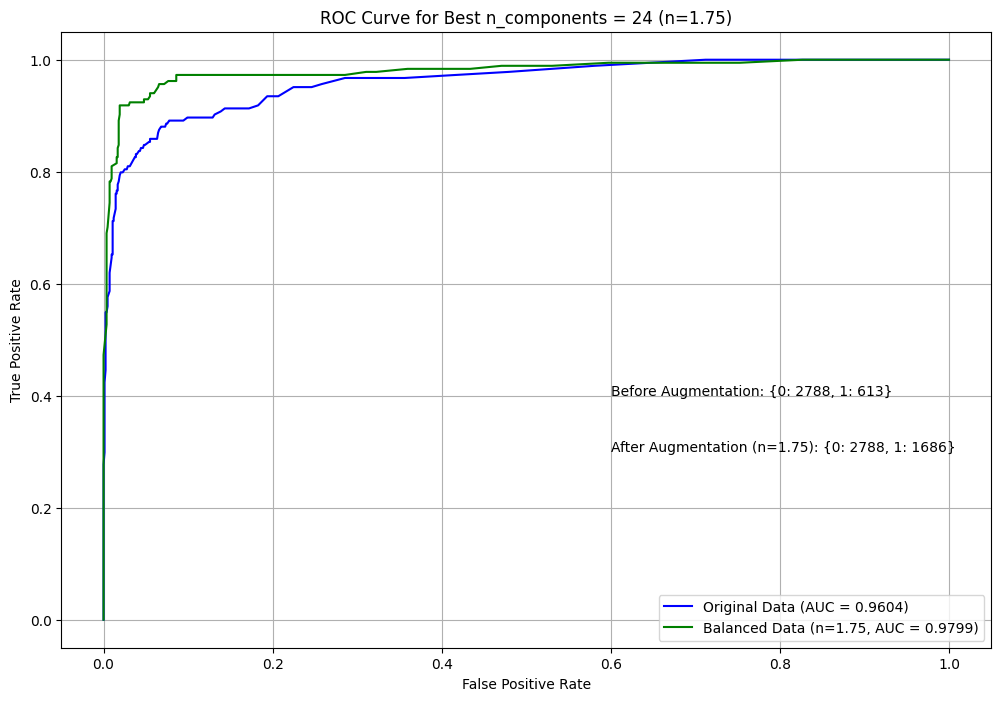


Results:
Recall (Original Data): 0.7989
Recall (Balanced Data, n=1.75): 0.9348

Classification Report (Original Data):
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       837
           1       0.89      0.80      0.84       184

    accuracy                           0.95      1021
   macro avg       0.92      0.89      0.90      1021
weighted avg       0.94      0.95      0.94      1021


Classification Report (Balanced Data, n=1.75):
              precision    recall  f1-score   support

           0       0.99      0.95      0.96       837
           1       0.79      0.93      0.86       184

    accuracy                           0.94      1021
   macro avg       0.89      0.94      0.91      1021
weighted avg       0.95      0.94      0.95      1021


Generating data with n = 2...
Class distribution after augmentation: Counter({0: 2788, 1: 1839})


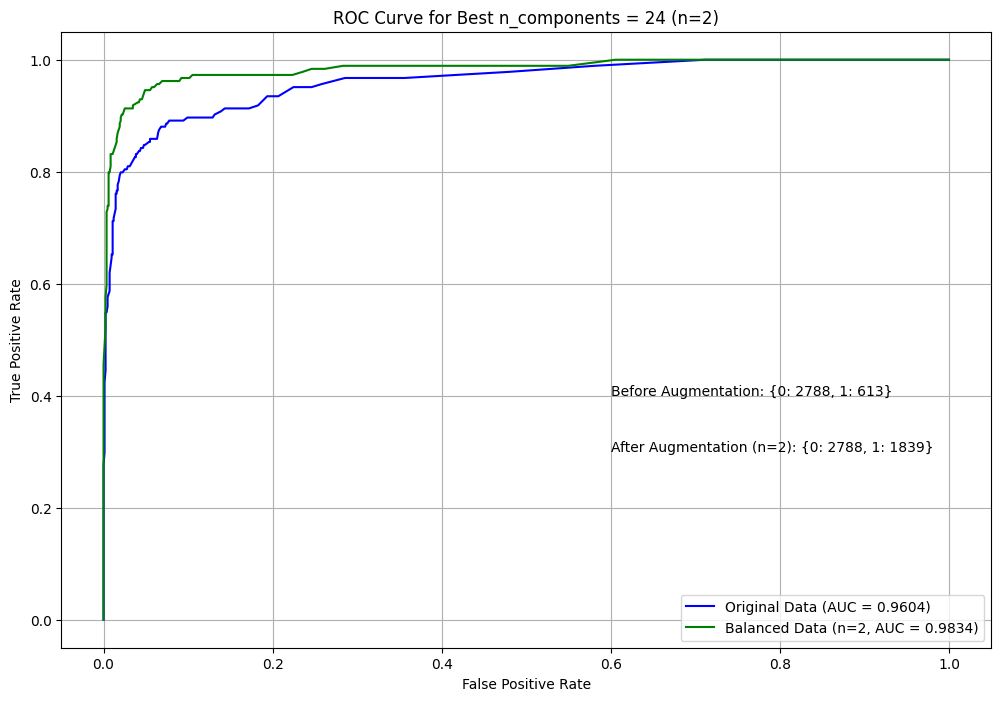


Results:
Recall (Original Data): 0.7989
Recall (Balanced Data, n=2): 0.9457

Classification Report (Original Data):
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       837
           1       0.89      0.80      0.84       184

    accuracy                           0.95      1021
   macro avg       0.92      0.89      0.90      1021
weighted avg       0.94      0.95      0.94      1021


Classification Report (Balanced Data, n=2):
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       837
           1       0.81      0.95      0.87       184

    accuracy                           0.95      1021
   macro avg       0.90      0.95      0.92      1021
weighted avg       0.95      0.95      0.95      1021


Generating data with n = 2.25...
Class distribution after augmentation: Counter({0: 2788, 1: 1992})


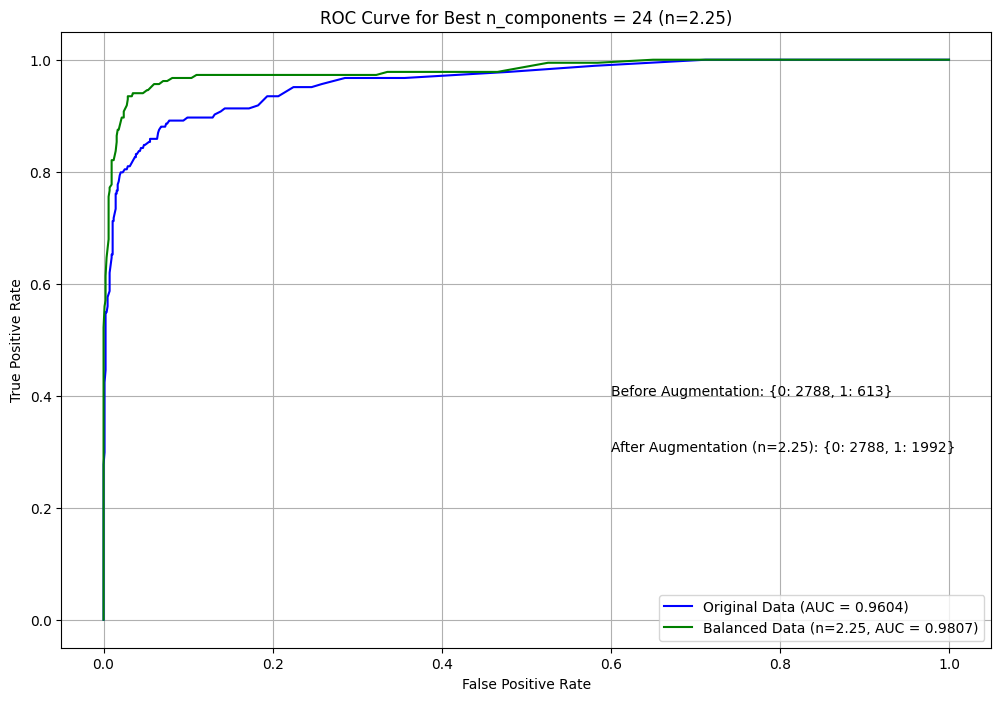


Results:
Recall (Original Data): 0.7989
Recall (Balanced Data, n=2.25): 0.9457

Classification Report (Original Data):
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       837
           1       0.89      0.80      0.84       184

    accuracy                           0.95      1021
   macro avg       0.92      0.89      0.90      1021
weighted avg       0.94      0.95      0.94      1021


Classification Report (Balanced Data, n=2.25):
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       837
           1       0.80      0.95      0.87       184

    accuracy                           0.95      1021
   macro avg       0.89      0.95      0.92      1021
weighted avg       0.95      0.95      0.95      1021


Generating data with n = 2.5...
Class distribution after augmentation: Counter({0: 2788, 1: 2145})


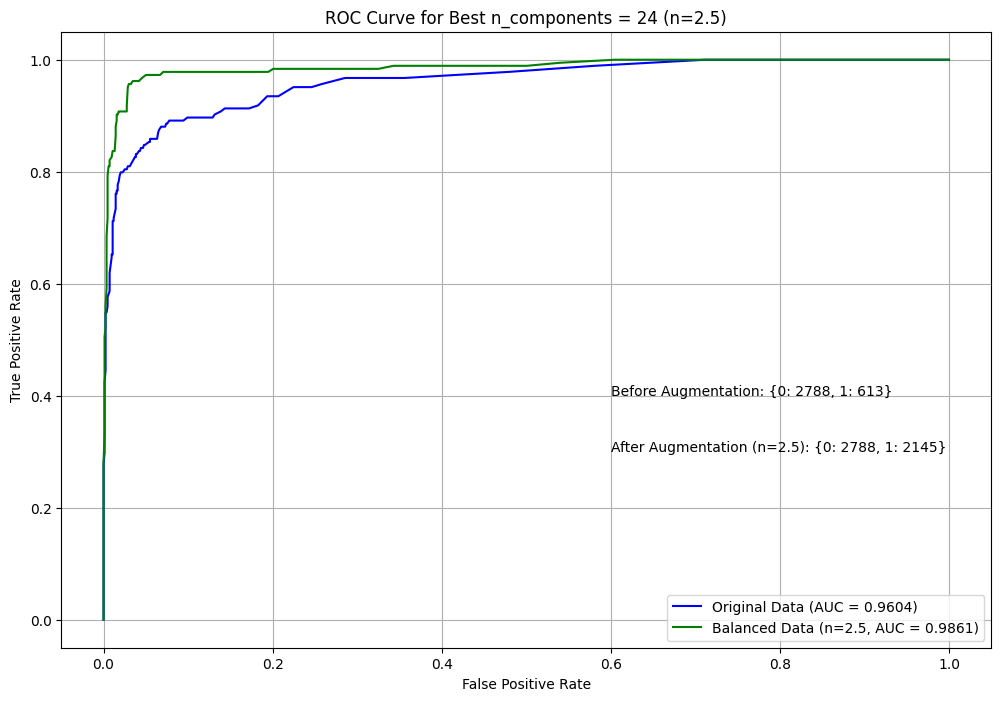


Results:
Recall (Original Data): 0.7989
Recall (Balanced Data, n=2.5): 0.9728

Classification Report (Original Data):
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       837
           1       0.89      0.80      0.84       184

    accuracy                           0.95      1021
   macro avg       0.92      0.89      0.90      1021
weighted avg       0.94      0.95      0.94      1021


Classification Report (Balanced Data, n=2.5):
              precision    recall  f1-score   support

           0       0.99      0.94      0.97       837
           1       0.78      0.97      0.86       184

    accuracy                           0.95      1021
   macro avg       0.89      0.96      0.92      1021
weighted avg       0.95      0.95      0.95      1021


Generating data with n = 2.75...
Class distribution after augmentation: Counter({0: 2788, 1: 2299})


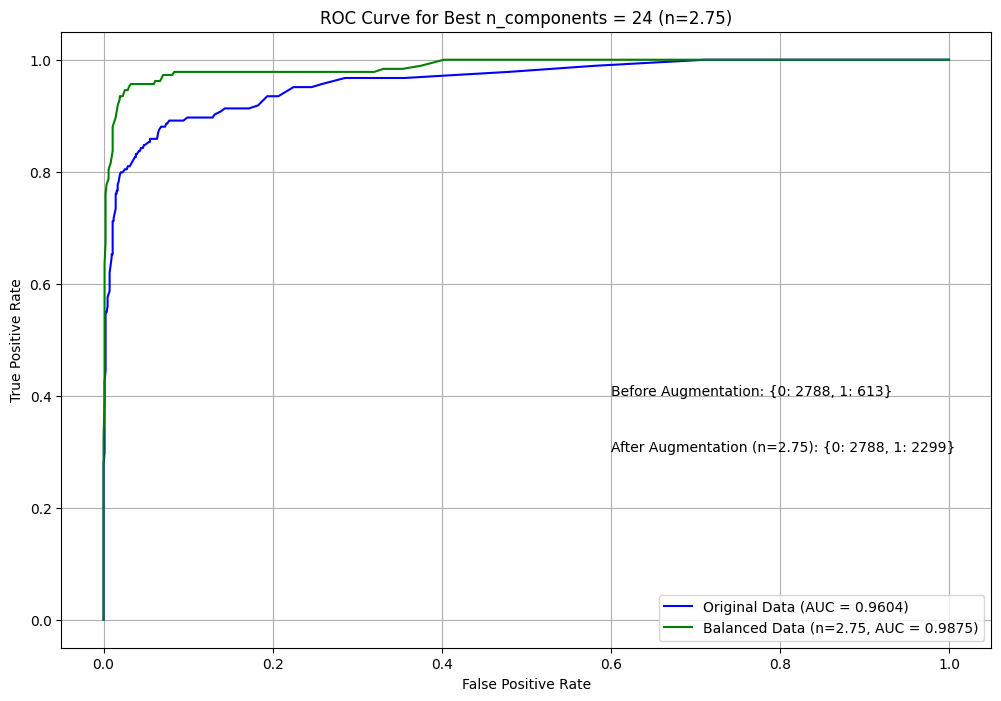


Results:
Recall (Original Data): 0.7989
Recall (Balanced Data, n=2.75): 0.9620

Classification Report (Original Data):
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       837
           1       0.89      0.80      0.84       184

    accuracy                           0.95      1021
   macro avg       0.92      0.89      0.90      1021
weighted avg       0.94      0.95      0.94      1021


Classification Report (Balanced Data, n=2.75):
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       837
           1       0.77      0.96      0.86       184

    accuracy                           0.94      1021
   macro avg       0.88      0.95      0.91      1021
weighted avg       0.95      0.94      0.94      1021


Generating data with n = 3...
Class distribution after augmentation: Counter({0: 2788, 1: 2452})


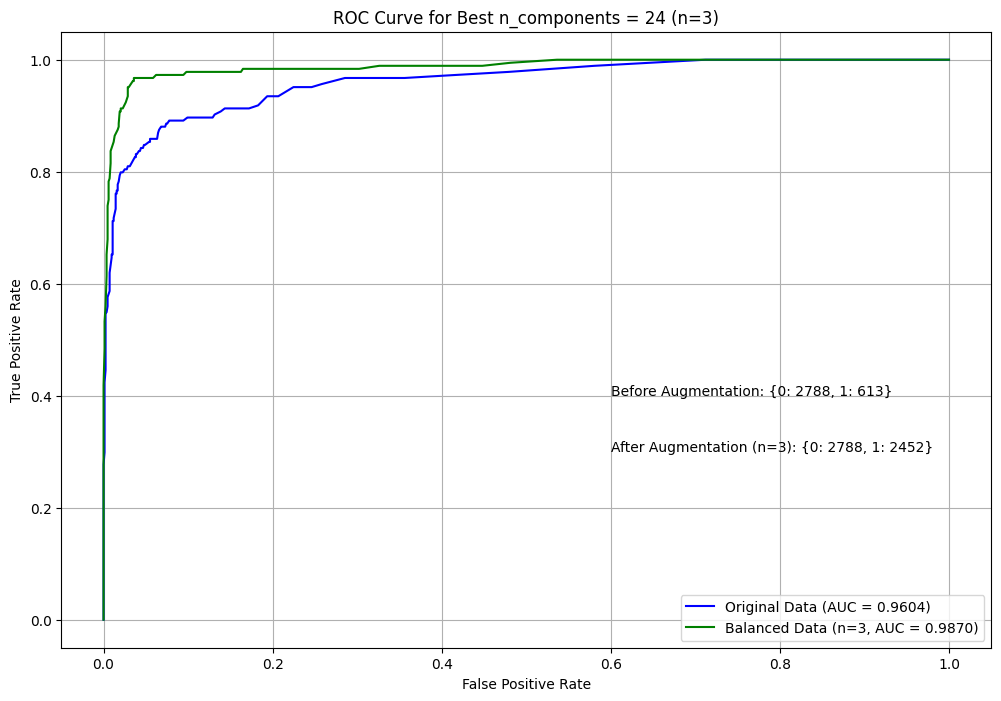


Results:
Recall (Original Data): 0.7989
Recall (Balanced Data, n=3): 0.9728

Classification Report (Original Data):
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       837
           1       0.89      0.80      0.84       184

    accuracy                           0.95      1021
   macro avg       0.92      0.89      0.90      1021
weighted avg       0.94      0.95      0.94      1021


Classification Report (Balanced Data, n=3):
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       837
           1       0.77      0.97      0.86       184

    accuracy                           0.94      1021
   macro avg       0.88      0.96      0.91      1021
weighted avg       0.95      0.94      0.95      1021



In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, auc, recall_score
from collections import Counter
from sklearn.decomposition import PCA
from ForestDiffusion import ForestDiffusionModel
import matplotlib.pyplot as plt

# Step 1: Load the data
data = pd.read_csv('reduced_spambase.csv')
X = data.iloc[:, :-1]  # Features (assuming target is the last column)
y = data.iloc[:, -1]  # Target

# Step 2: Feature selection using Random Forest
rf_feature_selector = RandomForestClassifier(random_state=42)
rf_feature_selector.fit(X, y)

# Get feature importances
importances = rf_feature_selector.feature_importances_
features = data.columns[:-1]  # Feature names

# Set a threshold for feature selection
threshold = 0.0097
selected_features = importances >= threshold
selected_feature_names = features[selected_features]
print(f"\nFeatures selected with importance >= {threshold}:")
for feature, importance in zip(features[selected_features], importances[selected_features]):
    print(f"{feature}: {importance:.4f}")

# Reduce dataset to selected features
X_selected = X.loc[:, selected_features]

# Step 3: Standardize the selected dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

# Step 4: Apply PCA and determine the optimal number of components using the Scree Method
pca = PCA()
pca.fit(X_scaled)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Scree Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, marker='o', label='Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Threshold')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.legend()
plt.grid()
plt.show()

# Find the optimal number of components
best_n_components = np.argmax(cumulative_variance_ratio >= 0.95) + 1
print(f"Optimal number of components: {best_n_components}")

# Step 5: Reduce dimensionality using the optimal number of components
pca = PCA(n_components=best_n_components)
X_reduced = pca.fit_transform(X_scaled)

# Step 6: Split the dataset into train and test (30% test data)
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=42, stratify=y)

# Step 7: Train a Random Forest classifier on the original dataset
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate recall on the original test set
y_pred = rf.predict(X_test)
recall_original = recall_score(y_test, y_pred)
classification_report_original = classification_report(y_test, y_pred)

# Calculate ROC curve and AUC for original data
fpr_original, tpr_original, _ = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
auc_original = auc(fpr_original, tpr_original)

# Step 8: Identify the minority class
class_counts = Counter(y)
minority_class = min(class_counts, key=class_counts.get)
print("Class distribution before augmentation:", class_counts)

# Step 9: Use ForestDiffusionModel to generate synthetic samples for the minority class
X_minority_reduced = X_reduced[y == minority_class]

forest_model = ForestDiffusionModel(
    X_minority_reduced,
    label_y=None,
    n_t=50,
    duplicate_K=100,
    bin_indexes=[],       # No binary columns in latent space
    cat_indexes=[],       # No categorical columns in latent space
    int_indexes=[],       # No integer columns in latent space
    diffusion_type='flow',
    n_jobs=-1
)

# Loop through different augmentation levels
n_values = [0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3]  # Different augmentation multipliers

for n in n_values:
    print(f"\nGenerating data with n = {n}...")

    # Generate synthetic samples
    num_samples_to_generate = round(len(X_minority_reduced) * n)
    generated_samples_reduced = forest_model.generate(batch_size=num_samples_to_generate)

    # Step 10: Add synthetic data to the original data in latent space
    X_balanced_reduced = np.vstack([X_reduced, generated_samples_reduced])
    y_balanced = np.hstack([y, [minority_class] * len(generated_samples_reduced)])

    class_counts_after = Counter(y_balanced)
    print("Class distribution after augmentation:", class_counts_after)

    # Step 11: Split the balanced dataset into train and test
    X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(
        X_balanced_reduced, y_balanced, test_size=0.3, random_state=42, stratify=y_balanced
    )

    # Train a Random Forest classifier on the balanced dataset
    rf_bal = RandomForestClassifier(random_state=42)
    rf_bal.fit(X_train_balanced, y_train_balanced)

    # Predict and evaluate recall on the balanced test set
    y_pred_balanced = rf_bal.predict(X_test)
    recall_balanced = recall_score(y_test, y_pred_balanced)
    classification_report_balanced = classification_report(y_test, y_pred_balanced)

    # Calculate ROC curve and AUC for balanced data
    fpr_balanced, tpr_balanced, _ = roc_curve(y_test, rf_bal.predict_proba(X_test)[:, 1])
    auc_balanced = auc(fpr_balanced, tpr_balanced)

    # Plot the ROC curves
    plt.figure(figsize=(12, 8))
    plt.plot(fpr_original, tpr_original, label=f'Original Data (AUC = {auc_original:.4f})', color='blue')
    plt.plot(fpr_balanced, tpr_balanced, label=f'Balanced Data (n={n}, AUC = {auc_balanced:.4f})', color='green')
    plt.title(f"ROC Curve for Best n_components = {best_n_components} (n={n})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)

    # Add class distributions as text on the plot
    plt.text(0.6, 0.4, f"Before Augmentation: {dict(class_counts)}", fontsize=10, color='black')
    plt.text(0.6, 0.3, f"After Augmentation (n={n}): {dict(class_counts_after)}", fontsize=10, color='black')
    plt.show()

    # Output the best results
    print("\nResults:")
    print(f"Recall (Original Data): {recall_original:.4f}")
    print(f"Recall (Balanced Data, n={n}): {recall_balanced:.4f}")
    print("\nClassification Report (Original Data):")
    print(classification_report_original)
    print(f"\nClassification Report (Balanced Data, n={n}):")
    print(classification_report_balanced)
